In [1]:
import numpy as np
import pandas as pd
import pickle

In [2]:
file = open("temp_model.pickle",'rb')
df = pickle.load(file)
df.head()

,DWG Number,RLocation,Tag,Area,Type,Loop Number,Location,Description,Manufacturer,Model Number,...,Supplied By,Status,Sequence Number,Suffix,Instrument Spec,Spec Issued,PO Issued,Signal Type 1,Signal Type 2,Signal Type 3
0,PID-143,"298,561",20-ZSC-7753.,NaN,ZSC,NaN,NaN,Closed Detection,NaN,NaN,...,With assembly,New,53.0,.,NaN,NaN,NaN,DIASI,NONE,NONE
1,PID-143,"300,561",20-XY-4101C,NaN,XY,NaN,NaN,3-Way Solenoid Valve,NaN,NaN,...,With assembly,NaN,1.0,C,NaN,NaN,NaN,DOASI,NONE,NONE
2,PID-143,NaN,20-ZSC-4101A,NaN,ZSC,NaN,NaN,Closed Detection,NaN,NaN,...,With assembly,NaN,1.0,A,NaN,NaN,NaN,DIASI,NONE,NONE
3,PID-143,"299,562",20-ZIS-4102K,NaN,ZIS,NaN,NaN,Pig Sensor,NaN,NaN,...,With assembly,NaN,2.0,K,NaN,NaN,NaN,DIASI,NONE,NONE
4,PID-143,NaN,20-XY-4101E,NaN,XY,NaN,NaN,3-Way Solenoid Valve,NaN,NaN,...,With assembly,NaN,1.0,E,NaN,NaN,NaN,DOASI,NONE,NONE


In [3]:
df.dtypes

DWG Number          object
RLocation           object
Tag                 object
Area               float64
Type                object
Loop Number        float64
Location           float64
Description         object
Manufacturer       float64
Model Number       float64
Comment            float64
Class Name          object
PnPID                int64
Area No            float64
Unit No            float64
Supplied By         object
Status              object
Sequence Number    float64
Suffix              object
Instrument Spec    float64
Spec Issued        float64
PO Issued          float64
Signal Type 1       object
Signal Type 2       object
Signal Type 3       object
dtype: object

In [4]:
lats = []
lons = []

for row in df['RLocation']:
    if type(row) != str:
        lat,lon = (None,None)
    else:
        lat,lon = tuple(str(row).split(','))
        lat = int(lat)
        lon = int(lon)
    lats.append(lat)
    lons.append(lon)
df["Lat"] = lats
df["Long"] = lons 

In [5]:
df['RLocation'].notna().head(20)

0      True
1      True
2     False
3      True
4     False
5      True
6      True
7     False
8      True
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16     True
17    False
18     True
19    False
Name: RLocation, dtype: bool

In [6]:
df_located = df[['RLocation','Lat','Long']][df['RLocation'].notna()]

In [7]:
df_located.describe()

,Lat,Long
count,97.000000,97.000000
mean,376.824742,292.587629
std,150.514673,190.005688
min,266.000000,83.000000
25%,294.000000,117.000000
50%,300.000000,158.000000
75%,535.000000,557.000000
max,774.000000,564.000000


In [8]:
X = np.array(df_located)
X = X[:,1:3]

In [9]:
X[:20]

array([[298.0, 561.0],
       [300.0, 561.0],
       [299.0, 562.0],
       [300.0, 561.0],
       [301.0, 562.0],
       [302.0, 563.0],
       [301.0, 564.0],
       [301.0, 564.0],
       [299.0, 563.0],
       [771.0, 289.0],
       [771.0, 291.0],
       [773.0, 292.0],
       [774.0, 293.0],
       [774.0, 292.0],
       [773.0, 292.0],
       [773.0, 292.0],
       [534.0, 315.0],
       [537.0, 318.0],
       [536.0, 316.0],
       [535.0, 318.0]], dtype=object)

In [10]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler


In [11]:
# Generate sample data
#centers = [[1, 1], [-1, -1], [1, -1]]
#X, labels_true = make_blobs(n_samples=750, centers=centers, cluster_std=0.4,
#                            random_state=0)

X = StandardScaler().fit_transform(X)

# #############################################################################
# Compute DBSCAN
# Higher min_samples or lower eps indicate higher density necessary to form a cluster.
db = DBSCAN(eps=0.03, min_samples=5).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
#print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
#print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
#print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
#print("Adjusted Rand Index: %0.3f"
#      % metrics.adjusted_rand_score(labels_true, labels))
#print("Adjusted Mutual Information: %0.3f"
#      % metrics.adjusted_mutual_info_score(labels_true, labels))
#print("Silhouette Coefficient: %0.3f"
#      % metrics.silhouette_score(X, labels))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

Estimated number of clusters: 7
Estimated number of noise points: 0


<Figure size 640x480 with 1 Axes>

In [12]:
db.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

#### With the small adjust ment in eps(cluster radius) and min_sample(minimum cluster size) we were a ble to group locations into clusters that represent unit. This allow us to bin the locations into each unit.

In [13]:
df_located["unit_label"] = db.labels_

In [14]:
df_located.index

Int64Index([  0,   1,   3,   5,   6,   8,  16,  18,  21,  27,  28,  29,  31,
             32,  33,  38,  44,  45,  46,  47,  51,  54,  55,  61,  62,  63,
             64,  65,  66,  79,  81,  83,  84,  85,  92,  96, 100, 101, 102,
            103, 104, 105, 118, 122, 123, 124, 135, 136, 137, 141, 142, 155,
            173, 176, 177, 179, 189, 197, 198, 199, 200, 202, 203, 206, 208,
            209, 210, 236, 237, 240, 241, 242, 243, 266, 267, 268, 269, 271,
            279, 287, 291, 295, 297, 299, 300, 303, 304, 307, 308, 309, 322,
            324, 325, 326, 328, 332, 337],
           dtype='int64')

In [15]:
df["unit_label"] = None
df.iloc[df_located.index, -1] = db.labels_

In [16]:
pd.set_option('display.max_rows',100)
df.iloc[:,[0,1,-1]][df["RLocation"].notna()]

,DWG Number,RLocation,unit_label
0,PID-143,"298,561",0
1,PID-143,"300,561",0
3,PID-143,"299,562",0
5,PID-143,"300,561",0
6,PID-143,"301,562",0
8,PID-143,"302,563",0
16,PID-143,"301,564",0
18,PID-143,"301,564",0
21,PID-143,"299,563",0
27,PID-101,"771,289",1


#### We can now use unit_label enumeration as a target variable. This effectively bined the locations into categorical variables. We can use these labeled location now as training set for the machine learning algorithm to classify each intrument tags into the location. In this data set, this will be trivial since P&ID number is tied directly 1 to 1 with the location. None the less, we can mix other attributes in and provide a general framework for predicting the location of the instrument tag.

In [17]:
groupby_unit_label_Lat = df[df['Lat'].notnull()].groupby('unit_label').mean()[['Lat','Long']]

In [18]:
groupby_unit_label_Lat = groupby_unit_label_Lat.rename(columns={'Lat':'Lat_mean','Long':'Long_mean'})

In [19]:
df = df.merge(groupby_unit_label_Lat, how = 'left', right_index = True, left_on = 'unit_label')

In [20]:
df_encoded = pd.get_dummies(df[['DWG Number','Type','Description','Suffix','Signal Type 1']], prefix=['DWG','Type','Description','Suffix','Signal Type 1'])

In [21]:
df.iloc[:,15:]

,Supplied By,Status,Sequence Number,Suffix,Instrument Spec,Spec Issued,PO Issued,Signal Type 1,Signal Type 2,Signal Type 3,Lat,Long,unit_label,Lat_mean,Long_mean
0,With assembly,New,53.0,.,NaN,NaN,NaN,DIASI,NONE,NONE,298.0,561.0,0,298.481481,561.222222
1,With assembly,NaN,1.0,C,NaN,NaN,NaN,DOASI,NONE,NONE,300.0,561.0,0,298.481481,561.222222
2,With assembly,NaN,1.0,A,NaN,NaN,NaN,DIASI,NONE,NONE,NaN,NaN,None,NaN,NaN
3,With assembly,NaN,2.0,K,NaN,NaN,NaN,DIASI,NONE,NONE,299.0,562.0,0,298.481481,561.222222
4,With assembly,NaN,1.0,E,NaN,NaN,NaN,DOASI,NONE,NONE,NaN,NaN,None,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,With assembly,NaN,3.0,G,NaN,NaN,NaN,DIASI,NONE,NONE,NaN,NaN,None,NaN,NaN
348,With assembly,NaN,5.0,K,NaN,NaN,NaN,DIASI,NONE,NONE,NaN,NaN,None,NaN,NaN
349,NaN,NaN,4.0,E,NaN,NaN,NaN,DIASI,DIASI,NONE,NaN,NaN,None,NaN,NaN
350,With assembly,NaN,3.0,J,NaN,NaN,NaN,DIASI,NONE,NONE,NaN,NaN,None,NaN,NaN


In [22]:
df_numeric = df[['Area No','Unit No','Sequence Number']]
df_numeric

,Area No,Unit No,Sequence Number
0,20.0,77.0,53.0
1,20.0,41.0,1.0
2,20.0,41.0,1.0
3,20.0,41.0,2.0
4,20.0,41.0,1.0
...,...,...,...
347,20.0,41.0,3.0
348,20.0,41.0,5.0
349,20.0,41.0,4.0
350,20.0,41.0,3.0


In [23]:
normalized_df = df_encoded.merge(df_numeric,left_index=True, right_index=True)

In [24]:
normalized_df.iloc[:,-40:].head()

,DWG_PID-132,DWG_PID-133,DWG_PID-141,DWG_PID-142,DWG_PID-143,Type_X1FV,Type_XPL,Type_XY,Type_ZIS,Type_ZSC,...,Suffix_J,Suffix_K,Suffix_M,Suffix_P,Signal Type 1_DIASI,Signal Type 1_DOASI,Signal Type 1_I/O,Area No,Unit No,Sequence Number
0,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,1,0,0,20.0,77.0,53.0
1,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,1,0,20.0,41.0,1.0
2,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,1,0,0,20.0,41.0,1.0
3,0,0,0,0,1,0,0,0,1,0,...,0,1,0,0,1,0,0,20.0,41.0,2.0
4,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,1,0,20.0,41.0,1.0


In [25]:
train_index = normalized_df[df["RLocation"].notna()].dropna().index

In [26]:
df

,DWG Number,RLocation,Tag,Area,Type,Loop Number,Location,Description,Manufacturer,Model Number,...,Spec Issued,PO Issued,Signal Type 1,Signal Type 2,Signal Type 3,Lat,Long,unit_label,Lat_mean,Long_mean
0,PID-143,"298,561",20-ZSC-7753.,NaN,ZSC,NaN,NaN,Closed Detection,NaN,NaN,...,NaN,NaN,DIASI,NONE,NONE,298.0,561.0,0,298.481481,561.222222
1,PID-143,"300,561",20-XY-4101C,NaN,XY,NaN,NaN,3-Way Solenoid Valve,NaN,NaN,...,NaN,NaN,DOASI,NONE,NONE,300.0,561.0,0,298.481481,561.222222
2,PID-143,NaN,20-ZSC-4101A,NaN,ZSC,NaN,NaN,Closed Detection,NaN,NaN,...,NaN,NaN,DIASI,NONE,NONE,NaN,NaN,None,NaN,NaN
3,PID-143,"299,562",20-ZIS-4102K,NaN,ZIS,NaN,NaN,Pig Sensor,NaN,NaN,...,NaN,NaN,DIASI,NONE,NONE,299.0,562.0,0,298.481481,561.222222
4,PID-143,NaN,20-XY-4101E,NaN,XY,NaN,NaN,3-Way Solenoid Valve,NaN,NaN,...,NaN,NaN,DOASI,NONE,NONE,NaN,NaN,None,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,PID-142,NaN,20-ZSC-4103G,NaN,ZSC,NaN,NaN,Closed Detection,NaN,NaN,...,NaN,NaN,DIASI,NONE,NONE,NaN,NaN,None,NaN,NaN
348,PID-142,NaN,20-ZIS-4105K,NaN,ZIS,NaN,NaN,Pig Sensor,NaN,NaN,...,NaN,NaN,DIASI,NONE,NONE,NaN,NaN,None,NaN,NaN
349,PID-142,NaN,20-ZSC/O-4104E,NaN,ZSC/O,NaN,NaN,Closed and Open Detection,NaN,NaN,...,NaN,NaN,DIASI,DIASI,NONE,NaN,NaN,None,NaN,NaN
350,PID-142,NaN,20-ZIS-4103J,NaN,ZIS,NaN,NaN,Pig Sensor,NaN,NaN,...,NaN,NaN,DIASI,NONE,NONE,NaN,NaN,None,NaN,NaN


In [27]:
df.iloc[train_index,:]

,DWG Number,RLocation,Tag,Area,Type,Loop Number,Location,Description,Manufacturer,Model Number,...,Spec Issued,PO Issued,Signal Type 1,Signal Type 2,Signal Type 3,Lat,Long,unit_label,Lat_mean,Long_mean
0,PID-143,"298,561",20-ZSC-7753.,NaN,ZSC,NaN,NaN,Closed Detection,NaN,NaN,...,NaN,NaN,DIASI,NONE,NONE,298.0,561.0,0,298.481481,561.222222
1,PID-143,"300,561",20-XY-4101C,NaN,XY,NaN,NaN,3-Way Solenoid Valve,NaN,NaN,...,NaN,NaN,DOASI,NONE,NONE,300.0,561.0,0,298.481481,561.222222
3,PID-143,"299,562",20-ZIS-4102K,NaN,ZIS,NaN,NaN,Pig Sensor,NaN,NaN,...,NaN,NaN,DIASI,NONE,NONE,299.0,562.0,0,298.481481,561.222222
5,PID-143,"300,561",20-XY-4102E,NaN,XY,NaN,NaN,3-Way Solenoid Valve,NaN,NaN,...,NaN,NaN,DOASI,NONE,NONE,300.0,561.0,0,298.481481,561.222222
6,PID-143,"301,562",20-XY-4101B,NaN,XY,NaN,NaN,3-Way Solenoid Valve,NaN,NaN,...,NaN,NaN,DOASI,NONE,NONE,301.0,562.0,0,298.481481,561.222222
8,PID-143,"302,563",20-ZSC-4101C,NaN,ZSC,NaN,NaN,Closed Detection,NaN,NaN,...,NaN,NaN,DIASI,NONE,NONE,302.0,563.0,0,298.481481,561.222222
16,PID-143,"301,564",20-ZSC-4102G,NaN,ZSC,NaN,NaN,Closed Detection,NaN,NaN,...,NaN,NaN,DIASI,NONE,NONE,301.0,564.0,0,298.481481,561.222222
18,PID-143,"301,564",20-ZSC/O-4101F,NaN,ZSC/O,NaN,NaN,Closed and Open Detection,NaN,NaN,...,NaN,NaN,DIASI,DIASI,NONE,301.0,564.0,0,298.481481,561.222222
21,PID-143,"299,563",20-XY-4102A,NaN,XY,NaN,NaN,3-Way Solenoid Valve,NaN,NaN,...,NaN,NaN,DOASI,NONE,NONE,299.0,563.0,0,298.481481,561.222222
27,PID-101,"771,289",20-XY-0101P,NaN,XY,NaN,NaN,4-Way Solenoid Valve,NaN,NaN,...,NaN,NaN,DOASI,NONE,NONE,771.0,289.0,1,772.714286,291.571429


In [28]:
X = np.array(normalized_df[df["RLocation"].notna()].dropna())
y = np.array(pd.get_dummies(df.iloc[train_index,:]["unit_label"]))
print(X.shape)
print(y.shape)

(96, 48)
(96, 7)


In [29]:
X[30]

array([ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  1., 20., 11.,  2.])

In [30]:
y

array([[1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0,

In [31]:
from sklearn.neighbors import KNeighborsClassifier
model_knn= KNeighborsClassifier(n_neighbors=5)
model_knn.fit(X,y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [32]:
test_index = normalized_df[df["RLocation"].isna()].dropna().index

In [33]:
normalized_df.iloc[test_index,:]

,DWG_PID-101,DWG_PID-102,DWG_PID-103,DWG_PID-111,DWG_PID-121,DWG_PID-122,DWG_PID-123,DWG_PID-131,DWG_PID-132,DWG_PID-133,...,Suffix_J,Suffix_K,Suffix_M,Suffix_P,Signal Type 1_DIASI,Signal Type 1_DOASI,Signal Type 1_I/O,Area No,Unit No,Sequence Number
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,20.0,41.0,1.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,20.0,41.0,1.0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,20.0,41.0,2.0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,20.0,41.0,2.0
10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,20.0,41.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,20.0,41.0,3.0
348,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,20.0,41.0,5.0
349,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,20.0,41.0,4.0
350,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,20.0,41.0,3.0


In [34]:
X_test = np.array(normalized_df.iloc[test_index,:])

In [35]:
y_pred = model_knn.predict(X_test)

In [36]:
y_pred.shape

(249, 7)

#### Below is a experimental attempt to use Matrix Factorization to reconstruct the missing unit information in the full dataset

# Begining of Experiment

In [37]:
from sklearn import preprocessing

#### Save index of the full dataset without NA

In [38]:
full_index = normalized_df.dropna().index

In [39]:
full_index.shape

(345,)

In [40]:
label_arr = np.array([df.iloc[full_index,:]["unit_label"]])

In [41]:
label_arr = np.reshape(label_arr,(label_arr.shape[1],1))

In [42]:
label_arr

array([[0],
       [0],
       [None],
       [0],
       [None],
       [0],
       [0],
       [None],
       [0],
       [None],
       [None],
       [None],
       [None],
       [None],
       [None],
       [None],
       [0],
       [None],
       [0],
       [None],
       [None],
       [0],
       [None],
       [None],
       [None],
       [None],
       [None],
       [1],
       [1],
       [1],
       [None],
       [1],
       [1],
       [1],
       [None],
       [None],
       [None],
       [None],
       [1],
       [None],
       [None],
       [None],
       [None],
       [None],
       [2],
       [2],
       [2],
       [2],
       [None],
       [None],
       [None],
       [2],
       [None],
       [None],
       [2],
       [2],
       [None],
       [None],
       [None],
       [None],
       [None],
       [3],
       [3],
       [3],
       [3],
       [3],
       [3],
       [None],
       [None],
       [None],
       [None],
       [None],
       

In [43]:
normalized_df.iloc[0,:]

DWG_PID-101                                               0.0
DWG_PID-102                                               0.0
DWG_PID-103                                               0.0
DWG_PID-111                                               0.0
DWG_PID-121                                               0.0
DWG_PID-122                                               0.0
DWG_PID-123                                               0.0
DWG_PID-131                                               0.0
DWG_PID-132                                               0.0
DWG_PID-133                                               0.0
DWG_PID-141                                               0.0
DWG_PID-142                                               0.0
DWG_PID-143                                               1.0
Type_X1FV                                                 0.0
Type_XPL                                                  0.0
Type_XY                                                   0.0
Type_ZIS

In [44]:
normalized_df.iloc[full_index,:]

,DWG_PID-101,DWG_PID-102,DWG_PID-103,DWG_PID-111,DWG_PID-121,DWG_PID-122,DWG_PID-123,DWG_PID-131,DWG_PID-132,DWG_PID-133,...,Suffix_J,Suffix_K,Suffix_M,Suffix_P,Signal Type 1_DIASI,Signal Type 1_DOASI,Signal Type 1_I/O,Area No,Unit No,Sequence Number
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,20.0,77.0,53.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,20.0,41.0,1.0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,20.0,41.0,1.0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,20.0,41.0,2.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,20.0,41.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,20.0,41.0,3.0
348,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,20.0,41.0,5.0
349,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,20.0,41.0,4.0
350,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,20.0,41.0,3.0


In [45]:
min_max_scaler = preprocessing.MinMaxScaler()
min_max_scaler.fit(normalized_df.iloc[full_index,:])
X_full = min_max_scaler.transform(normalized_df.iloc[full_index,:])

In [46]:
X_full.shape

(345, 48)

In [47]:
label_arr.shape

(345, 1)

In [48]:
X_full = np.hstack([X_full,label_arr])

In [49]:
X_full.shape

(345, 49)

In [50]:
GradientDescent_Flag_Mat = (X_full == None)

In [69]:
def matrix_factorization(R, P, Q, K,Flag_Mat, steps=3000, alpha=0.0002, beta=0.02):
    
    ### R = The user x item rating matrix (m x n)
    ### P = Initial user-factor matrix (m x k)
    ### Q = Initial item-factor matrix (n x k)
    ### K = The number of latent factors (features)
    ### steps = The number of epochs in gradient descent
    ### alpha = The learning rate for gradient descent
    ### beta = The regularization coefficient
    
    Q = Q.T
    for step in range(steps):
        for i in range(len(R)):
            for j in range(len(R[i])):
                if Flag_Mat[i][j] == False:
                    eij = R[i][j] - np.dot(P[i,:],Q[:,j])
                    for k in range(K):
                        ### update P and Q based on the partial derivatives
                        P[i][k] = P[i][k] + alpha * (2 * eij * Q[k][j] - beta * P[i][k])
                        Q[k][j] = Q[k][j] + alpha * (2 * eij * P[i][k] - beta * Q[k][j])
        eR = np.dot(P,Q)
        e = 0
        for i in range(len(R)):
            for j in range(len(R[i])):
                if Flag_Mat[i][j] == False:
                    e = e + pow(R[i][j] - np.dot(P[i,:],Q[:,j]), 2)
                    for k in range(K):
                        e = e + (beta/2) * ( pow(P[i][k],2) + pow(Q[k][j],2) )
        if e < 0.001:
            break
        print("Step %d of %d; Error: %0.5f; Time: %0.2f" %(step+1, steps, e, time()))
    return P, Q.T

In [70]:
#Ratings = np.array(pd.DataFrame(X_full).fillna(0))
Ratings = np.array(X_full)

In [71]:
X_full.shape[1]

49

In [72]:
M = X_full.shape[0]
N = X_full.shape[1]
K = k
steps = 10000

In [73]:
### Initialize P and Q to random values
P = np.random.rand(M,K)
Q = np.random.rand(N,K)

In [74]:
from time import time
t0 = time()
fP, fQ = matrix_factorization(Ratings, P, Q, K, GradientDescent_Flag_Mat, steps=steps)
print("done in %0.3fs." % (time() - t0))

Step 1 of 10000; Error: 25191.62490; Time: 1583040372.02
Step 2 of 10000; Error: 17134.26282; Time: 1583040372.85
Step 3 of 10000; Error: 12177.32477; Time: 1583040373.61
Step 4 of 10000; Error: 9026.29831; Time: 1583040374.33
Step 5 of 10000; Error: 6977.16183; Time: 1583040375.03
Step 6 of 10000; Error: 5622.44873; Time: 1583040375.80
Step 7 of 10000; Error: 4715.40700; Time: 1583040376.56
Step 8 of 10000; Error: 4101.63003; Time: 1583040377.33
Step 9 of 10000; Error: 3682.18945; Time: 1583040378.12
Step 10 of 10000; Error: 3392.61959; Time: 1583040378.96
Step 11 of 10000; Error: 3190.39879; Time: 1583040379.75
Step 12 of 10000; Error: 3047.23319; Time: 1583040380.54
Step 13 of 10000; Error: 2944.17562; Time: 1583040381.27
Step 14 of 10000; Error: 2868.47761; Time: 1583040382.08
Step 15 of 10000; Error: 2811.52999; Time: 1583040382.81
Step 16 of 10000; Error: 2767.50164; Time: 1583040383.51
Step 17 of 10000; Error: 2732.43277; Time: 1583040384.35
Step 18 of 10000; Error: 2703.62773; 

Step 145 of 10000; Error: 1922.36667; Time: 1583040482.70
Step 146 of 10000; Error: 1919.82511; Time: 1583040483.50
Step 147 of 10000; Error: 1917.30487; Time: 1583040484.28
Step 148 of 10000; Error: 1914.80573; Time: 1583040485.04
Step 149 of 10000; Error: 1912.32745; Time: 1583040485.82
Step 150 of 10000; Error: 1909.86980; Time: 1583040486.61
Step 151 of 10000; Error: 1907.43256; Time: 1583040487.43
Step 152 of 10000; Error: 1905.01551; Time: 1583040488.21
Step 153 of 10000; Error: 1902.61844; Time: 1583040489.02
Step 154 of 10000; Error: 1900.24112; Time: 1583040489.71
Step 155 of 10000; Error: 1897.88336; Time: 1583040490.41
Step 156 of 10000; Error: 1895.54495; Time: 1583040491.19
Step 157 of 10000; Error: 1893.22569; Time: 1583040492.00
Step 158 of 10000; Error: 1890.92537; Time: 1583040492.82
Step 159 of 10000; Error: 1888.64382; Time: 1583040493.54
Step 160 of 10000; Error: 1886.38082; Time: 1583040494.27
Step 161 of 10000; Error: 1884.13621; Time: 1583040495.03
Step 162 of 10

Step 287 of 10000; Error: 1704.22411; Time: 1583040592.67
Step 288 of 10000; Error: 1703.35314; Time: 1583040593.49
Step 289 of 10000; Error: 1702.48771; Time: 1583040594.29
Step 290 of 10000; Error: 1701.62775; Time: 1583040595.06
Step 291 of 10000; Error: 1700.77321; Time: 1583040595.80
Step 292 of 10000; Error: 1699.92402; Time: 1583040596.63
Step 293 of 10000; Error: 1699.08012; Time: 1583040597.43
Step 294 of 10000; Error: 1698.24145; Time: 1583040598.21
Step 295 of 10000; Error: 1697.40796; Time: 1583040598.96
Step 296 of 10000; Error: 1696.57957; Time: 1583040599.74
Step 297 of 10000; Error: 1695.75624; Time: 1583040600.54
Step 298 of 10000; Error: 1694.93790; Time: 1583040601.34
Step 299 of 10000; Error: 1694.12449; Time: 1583040602.13
Step 300 of 10000; Error: 1693.31596; Time: 1583040602.88
Step 301 of 10000; Error: 1692.51224; Time: 1583040603.67
Step 302 of 10000; Error: 1691.71328; Time: 1583040604.34
Step 303 of 10000; Error: 1690.91903; Time: 1583040605.18
Step 304 of 10

Step 429 of 10000; Error: 1612.06676; Time: 1583040702.36
Step 430 of 10000; Error: 1611.50347; Time: 1583040703.17
Step 431 of 10000; Error: 1610.93984; Time: 1583040703.97
Step 432 of 10000; Error: 1610.37585; Time: 1583040704.65
Step 433 of 10000; Error: 1609.81148; Time: 1583040705.41
Step 434 of 10000; Error: 1609.24669; Time: 1583040706.15
Step 435 of 10000; Error: 1608.68147; Time: 1583040706.96
Step 436 of 10000; Error: 1608.11580; Time: 1583040707.70
Step 437 of 10000; Error: 1607.54965; Time: 1583040708.48
Step 438 of 10000; Error: 1606.98300; Time: 1583040709.16
Step 439 of 10000; Error: 1606.41582; Time: 1583040709.96
Step 440 of 10000; Error: 1605.84811; Time: 1583040710.66
Step 441 of 10000; Error: 1605.27982; Time: 1583040711.48
Step 442 of 10000; Error: 1604.71095; Time: 1583040712.21
Step 443 of 10000; Error: 1604.14147; Time: 1583040712.96
Step 444 of 10000; Error: 1603.57136; Time: 1583040713.72
Step 445 of 10000; Error: 1603.00060; Time: 1583040714.51
Step 446 of 10

Step 571 of 10000; Error: 1520.93550; Time: 1583040812.36
Step 572 of 10000; Error: 1520.18284; Time: 1583040813.16
Step 573 of 10000; Error: 1519.42855; Time: 1583040813.95
Step 574 of 10000; Error: 1518.67265; Time: 1583040814.75
Step 575 of 10000; Error: 1517.91515; Time: 1583040815.56
Step 576 of 10000; Error: 1517.15604; Time: 1583040816.38
Step 577 of 10000; Error: 1516.39534; Time: 1583040817.11
Step 578 of 10000; Error: 1515.63305; Time: 1583040817.92
Step 579 of 10000; Error: 1514.86919; Time: 1583040818.73
Step 580 of 10000; Error: 1514.10376; Time: 1583040819.42
Step 581 of 10000; Error: 1513.33677; Time: 1583040820.23
Step 582 of 10000; Error: 1512.56822; Time: 1583040820.92
Step 583 of 10000; Error: 1511.79813; Time: 1583040821.63
Step 584 of 10000; Error: 1511.02651; Time: 1583040822.31
Step 585 of 10000; Error: 1510.25336; Time: 1583040823.04
Step 586 of 10000; Error: 1509.47869; Time: 1583040823.77
Step 587 of 10000; Error: 1508.70252; Time: 1583040824.60
Step 588 of 10

Step 713 of 10000; Error: 1404.07257; Time: 1583040922.43
Step 714 of 10000; Error: 1403.23899; Time: 1583040923.23
Step 715 of 10000; Error: 1402.40621; Time: 1583040923.94
Step 716 of 10000; Error: 1401.57424; Time: 1583040924.70
Step 717 of 10000; Error: 1400.74311; Time: 1583040925.48
Step 718 of 10000; Error: 1399.91283; Time: 1583040926.22
Step 719 of 10000; Error: 1399.08341; Time: 1583040927.00
Step 720 of 10000; Error: 1398.25489; Time: 1583040927.68
Step 721 of 10000; Error: 1397.42727; Time: 1583040928.50
Step 722 of 10000; Error: 1396.60057; Time: 1583040929.31
Step 723 of 10000; Error: 1395.77481; Time: 1583040930.08
Step 724 of 10000; Error: 1394.95001; Time: 1583040930.91
Step 725 of 10000; Error: 1394.12618; Time: 1583040931.74
Step 726 of 10000; Error: 1393.30334; Time: 1583040932.50
Step 727 of 10000; Error: 1392.48151; Time: 1583040933.16
Step 728 of 10000; Error: 1391.66070; Time: 1583040933.91
Step 729 of 10000; Error: 1390.84093; Time: 1583040934.73
Step 730 of 10

Step 855 of 10000; Error: 1299.41226; Time: 1583041032.21
Step 856 of 10000; Error: 1298.79294; Time: 1583041033.02
Step 857 of 10000; Error: 1298.17527; Time: 1583041033.75
Step 858 of 10000; Error: 1297.55923; Time: 1583041034.55
Step 859 of 10000; Error: 1296.94482; Time: 1583041035.32
Step 860 of 10000; Error: 1296.33204; Time: 1583041036.09
Step 861 of 10000; Error: 1295.72089; Time: 1583041036.85
Step 862 of 10000; Error: 1295.11135; Time: 1583041037.68
Step 863 of 10000; Error: 1294.50343; Time: 1583041038.52
Step 864 of 10000; Error: 1293.89711; Time: 1583041039.33
Step 865 of 10000; Error: 1293.29240; Time: 1583041040.07
Step 866 of 10000; Error: 1292.68928; Time: 1583041040.76
Step 867 of 10000; Error: 1292.08776; Time: 1583041041.53
Step 868 of 10000; Error: 1291.48782; Time: 1583041042.35
Step 869 of 10000; Error: 1290.88946; Time: 1583041043.13
Step 870 of 10000; Error: 1290.29267; Time: 1583041043.83
Step 871 of 10000; Error: 1289.69746; Time: 1583041044.61
Step 872 of 10

Step 997 of 10000; Error: 1224.98793; Time: 1583041142.52
Step 998 of 10000; Error: 1224.53796; Time: 1583041143.32
Step 999 of 10000; Error: 1224.08873; Time: 1583041144.13
Step 1000 of 10000; Error: 1223.64023; Time: 1583041144.89
Step 1001 of 10000; Error: 1223.19247; Time: 1583041145.63
Step 1002 of 10000; Error: 1222.74544; Time: 1583041146.45
Step 1003 of 10000; Error: 1222.29913; Time: 1583041147.28
Step 1004 of 10000; Error: 1221.85354; Time: 1583041148.08
Step 1005 of 10000; Error: 1221.40865; Time: 1583041148.79
Step 1006 of 10000; Error: 1220.96448; Time: 1583041149.50
Step 1007 of 10000; Error: 1220.52101; Time: 1583041150.31
Step 1008 of 10000; Error: 1220.07824; Time: 1583041151.10
Step 1009 of 10000; Error: 1219.63616; Time: 1583041151.89
Step 1010 of 10000; Error: 1219.19477; Time: 1583041152.57
Step 1011 of 10000; Error: 1218.75406; Time: 1583041153.39
Step 1012 of 10000; Error: 1218.31403; Time: 1583041154.19
Step 1013 of 10000; Error: 1217.87468; Time: 1583041155.02


Step 1136 of 10000; Error: 1167.86868; Time: 1583041249.80
Step 1137 of 10000; Error: 1167.48853; Time: 1583041250.57
Step 1138 of 10000; Error: 1167.10874; Time: 1583041251.24
Step 1139 of 10000; Error: 1166.72930; Time: 1583041251.94
Step 1140 of 10000; Error: 1166.35022; Time: 1583041252.61
Step 1141 of 10000; Error: 1165.97150; Time: 1583041253.32
Step 1142 of 10000; Error: 1165.59314; Time: 1583041254.10
Step 1143 of 10000; Error: 1165.21513; Time: 1583041254.87
Step 1144 of 10000; Error: 1164.83747; Time: 1583041255.54
Step 1145 of 10000; Error: 1164.46017; Time: 1583041256.35
Step 1146 of 10000; Error: 1164.08322; Time: 1583041257.11
Step 1147 of 10000; Error: 1163.70663; Time: 1583041257.93
Step 1148 of 10000; Error: 1163.33038; Time: 1583041258.74
Step 1149 of 10000; Error: 1162.95449; Time: 1583041259.54
Step 1150 of 10000; Error: 1162.57894; Time: 1583041260.23
Step 1151 of 10000; Error: 1162.20375; Time: 1583041261.00
Step 1152 of 10000; Error: 1161.82891; Time: 1583041261.

Step 1275 of 10000; Error: 1118.31204; Time: 1583041357.29
Step 1276 of 10000; Error: 1117.97943; Time: 1583041358.13
Step 1277 of 10000; Error: 1117.64716; Time: 1583041358.93
Step 1278 of 10000; Error: 1117.31524; Time: 1583041359.65
Step 1279 of 10000; Error: 1116.98368; Time: 1583041360.42
Step 1280 of 10000; Error: 1116.65247; Time: 1583041361.26
Step 1281 of 10000; Error: 1116.32161; Time: 1583041362.04
Step 1282 of 10000; Error: 1115.99110; Time: 1583041362.73
Step 1283 of 10000; Error: 1115.66095; Time: 1583041363.50
Step 1284 of 10000; Error: 1115.33115; Time: 1583041364.24
Step 1285 of 10000; Error: 1115.00170; Time: 1583041364.96
Step 1286 of 10000; Error: 1114.67261; Time: 1583041365.67
Step 1287 of 10000; Error: 1114.34387; Time: 1583041366.48
Step 1288 of 10000; Error: 1114.01549; Time: 1583041367.28
Step 1289 of 10000; Error: 1113.68746; Time: 1583041368.02
Step 1290 of 10000; Error: 1113.35978; Time: 1583041368.75
Step 1291 of 10000; Error: 1113.03247; Time: 1583041369.

Step 1414 of 10000; Error: 1075.57227; Time: 1583041464.13
Step 1415 of 10000; Error: 1075.29101; Time: 1583041464.81
Step 1416 of 10000; Error: 1075.01013; Time: 1583041465.59
Step 1417 of 10000; Error: 1074.72963; Time: 1583041466.37
Step 1418 of 10000; Error: 1074.44951; Time: 1583041467.24
Step 1419 of 10000; Error: 1074.16978; Time: 1583041468.09
Step 1420 of 10000; Error: 1073.89042; Time: 1583041468.80
Step 1421 of 10000; Error: 1073.61144; Time: 1583041469.59
Step 1422 of 10000; Error: 1073.33285; Time: 1583041470.42
Step 1423 of 10000; Error: 1073.05463; Time: 1583041471.18
Step 1424 of 10000; Error: 1072.77680; Time: 1583041471.88
Step 1425 of 10000; Error: 1072.49934; Time: 1583041472.68
Step 1426 of 10000; Error: 1072.22227; Time: 1583041473.44
Step 1427 of 10000; Error: 1071.94558; Time: 1583041474.25
Step 1428 of 10000; Error: 1071.66926; Time: 1583041475.09
Step 1429 of 10000; Error: 1071.39333; Time: 1583041475.88
Step 1430 of 10000; Error: 1071.11778; Time: 1583041476.

Step 1553 of 10000; Error: 1040.08299; Time: 1583041571.15
Step 1554 of 10000; Error: 1039.85332; Time: 1583041571.89
Step 1555 of 10000; Error: 1039.62401; Time: 1583041572.73
Step 1556 of 10000; Error: 1039.39505; Time: 1583041573.57
Step 1557 of 10000; Error: 1039.16644; Time: 1583041574.33
Step 1558 of 10000; Error: 1038.93819; Time: 1583041575.01
Step 1559 of 10000; Error: 1038.71028; Time: 1583041575.77
Step 1560 of 10000; Error: 1038.48273; Time: 1583041576.58
Step 1561 of 10000; Error: 1038.25552; Time: 1583041577.25
Step 1562 of 10000; Error: 1038.02866; Time: 1583041578.04
Step 1563 of 10000; Error: 1037.80216; Time: 1583041578.76
Step 1564 of 10000; Error: 1037.57600; Time: 1583041579.48
Step 1565 of 10000; Error: 1037.35019; Time: 1583041580.32
Step 1566 of 10000; Error: 1037.12473; Time: 1583041581.12
Step 1567 of 10000; Error: 1036.89961; Time: 1583041581.81
Step 1568 of 10000; Error: 1036.67485; Time: 1583041582.55
Step 1569 of 10000; Error: 1036.45043; Time: 1583041583.

Step 1691 of 10000; Error: 1011.53044; Time: 1583041677.90
Step 1692 of 10000; Error: 1011.34507; Time: 1583041678.59
Step 1693 of 10000; Error: 1011.15998; Time: 1583041679.37
Step 1694 of 10000; Error: 1010.97518; Time: 1583041680.15
Step 1695 of 10000; Error: 1010.79066; Time: 1583041681.00
Step 1696 of 10000; Error: 1010.60643; Time: 1583041681.76
Step 1697 of 10000; Error: 1010.42248; Time: 1583041682.49
Step 1698 of 10000; Error: 1010.23881; Time: 1583041683.32
Step 1699 of 10000; Error: 1010.05542; Time: 1583041684.13
Step 1700 of 10000; Error: 1009.87232; Time: 1583041684.88
Step 1701 of 10000; Error: 1009.68950; Time: 1583041685.71
Step 1702 of 10000; Error: 1009.50695; Time: 1583041686.50
Step 1703 of 10000; Error: 1009.32469; Time: 1583041687.18
Step 1704 of 10000; Error: 1009.14271; Time: 1583041687.97
Step 1705 of 10000; Error: 1008.96100; Time: 1583041688.77
Step 1706 of 10000; Error: 1008.77957; Time: 1583041689.43
Step 1707 of 10000; Error: 1008.59842; Time: 1583041690.

Step 1832 of 10000; Error: 987.95696; Time: 1583041786.64
Step 1833 of 10000; Error: 987.80639; Time: 1583041787.35
Step 1834 of 10000; Error: 987.65602; Time: 1583041788.15
Step 1835 of 10000; Error: 987.50587; Time: 1583041788.96
Step 1836 of 10000; Error: 987.35592; Time: 1583041789.76
Step 1837 of 10000; Error: 987.20618; Time: 1583041790.53
Step 1838 of 10000; Error: 987.05665; Time: 1583041791.24
Step 1839 of 10000; Error: 986.90732; Time: 1583041792.06
Step 1840 of 10000; Error: 986.75819; Time: 1583041792.90
Step 1841 of 10000; Error: 986.60928; Time: 1583041793.69
Step 1842 of 10000; Error: 986.46056; Time: 1583041794.49
Step 1843 of 10000; Error: 986.31205; Time: 1583041795.23
Step 1844 of 10000; Error: 986.16375; Time: 1583041795.93
Step 1845 of 10000; Error: 986.01564; Time: 1583041796.62
Step 1846 of 10000; Error: 985.86774; Time: 1583041797.45
Step 1847 of 10000; Error: 985.72004; Time: 1583041798.26
Step 1848 of 10000; Error: 985.57254; Time: 1583041798.98
Step 1849 of 1

Step 1974 of 10000; Error: 968.43543; Time: 1583041899.51
Step 1975 of 10000; Error: 968.30970; Time: 1583041900.34
Step 1976 of 10000; Error: 968.18412; Time: 1583041901.30
Step 1977 of 10000; Error: 968.05868; Time: 1583041902.05
Step 1978 of 10000; Error: 967.93338; Time: 1583041902.84
Step 1979 of 10000; Error: 967.80823; Time: 1583041903.75
Step 1980 of 10000; Error: 967.68321; Time: 1583041904.62
Step 1981 of 10000; Error: 967.55835; Time: 1583041905.52
Step 1982 of 10000; Error: 967.43362; Time: 1583041906.41
Step 1983 of 10000; Error: 967.30903; Time: 1583041907.15
Step 1984 of 10000; Error: 967.18459; Time: 1583041907.91
Step 1985 of 10000; Error: 967.06029; Time: 1583041908.66
Step 1986 of 10000; Error: 966.93612; Time: 1583041909.56
Step 1987 of 10000; Error: 966.81210; Time: 1583041910.27
Step 1988 of 10000; Error: 966.68822; Time: 1583041911.09
Step 1989 of 10000; Error: 966.56447; Time: 1583041911.88
Step 1990 of 10000; Error: 966.44087; Time: 1583041912.67
Step 1991 of 1

Step 2116 of 10000; Error: 951.86913; Time: 1583042017.32
Step 2117 of 10000; Error: 951.76066; Time: 1583042018.06
Step 2118 of 10000; Error: 951.65230; Time: 1583042018.87
Step 2119 of 10000; Error: 951.54403; Time: 1583042019.61
Step 2120 of 10000; Error: 951.43587; Time: 1583042020.47
Step 2121 of 10000; Error: 951.32781; Time: 1583042021.24
Step 2122 of 10000; Error: 951.21985; Time: 1583042022.01
Step 2123 of 10000; Error: 951.11199; Time: 1583042022.78
Step 2124 of 10000; Error: 951.00424; Time: 1583042023.60
Step 2125 of 10000; Error: 950.89658; Time: 1583042024.40
Step 2126 of 10000; Error: 950.78903; Time: 1583042025.20
Step 2127 of 10000; Error: 950.68157; Time: 1583042025.93
Step 2128 of 10000; Error: 950.57422; Time: 1583042026.75
Step 2129 of 10000; Error: 950.46697; Time: 1583042027.56
Step 2130 of 10000; Error: 950.35981; Time: 1583042028.32
Step 2131 of 10000; Error: 950.25276; Time: 1583042029.02
Step 2132 of 10000; Error: 950.14581; Time: 1583042029.84
Step 2133 of 1

Step 2258 of 10000; Error: 937.40957; Time: 1583042129.24
Step 2259 of 10000; Error: 937.31399; Time: 1583042129.96
Step 2260 of 10000; Error: 937.21850; Time: 1583042130.71
Step 2261 of 10000; Error: 937.12309; Time: 1583042131.54
Step 2262 of 10000; Error: 937.02776; Time: 1583042132.35
Step 2263 of 10000; Error: 936.93251; Time: 1583042133.14
Step 2264 of 10000; Error: 936.83734; Time: 1583042133.90
Step 2265 of 10000; Error: 936.74226; Time: 1583042134.65
Step 2266 of 10000; Error: 936.64725; Time: 1583042135.41
Step 2267 of 10000; Error: 936.55233; Time: 1583042136.24
Step 2268 of 10000; Error: 936.45749; Time: 1583042137.04
Step 2269 of 10000; Error: 936.36274; Time: 1583042137.83
Step 2270 of 10000; Error: 936.26806; Time: 1583042138.60
Step 2271 of 10000; Error: 936.17346; Time: 1583042139.33
Step 2272 of 10000; Error: 936.07895; Time: 1583042140.06
Step 2273 of 10000; Error: 935.98452; Time: 1583042140.84
Step 2274 of 10000; Error: 935.89016; Time: 1583042141.66
Step 2275 of 1

Step 2400 of 10000; Error: 924.63177; Time: 1583042239.04
Step 2401 of 10000; Error: 924.54731; Time: 1583042239.83
Step 2402 of 10000; Error: 924.46294; Time: 1583042240.53
Step 2403 of 10000; Error: 924.37863; Time: 1583042241.36
Step 2404 of 10000; Error: 924.29441; Time: 1583042242.15
Step 2405 of 10000; Error: 924.21025; Time: 1583042242.86
Step 2406 of 10000; Error: 924.12618; Time: 1583042243.65
Step 2407 of 10000; Error: 924.04218; Time: 1583042244.46
Step 2408 of 10000; Error: 923.95826; Time: 1583042245.29
Step 2409 of 10000; Error: 923.87441; Time: 1583042246.04
Step 2410 of 10000; Error: 923.79064; Time: 1583042246.84
Step 2411 of 10000; Error: 923.70694; Time: 1583042247.60
Step 2412 of 10000; Error: 923.62332; Time: 1583042248.43
Step 2413 of 10000; Error: 923.53978; Time: 1583042249.10
Step 2414 of 10000; Error: 923.45631; Time: 1583042249.92
Step 2415 of 10000; Error: 923.37292; Time: 1583042250.72
Step 2416 of 10000; Error: 923.28961; Time: 1583042251.54
Step 2417 of 1

Step 2542 of 10000; Error: 913.39617; Time: 1583042348.21
Step 2543 of 10000; Error: 913.32243; Time: 1583042348.91
Step 2544 of 10000; Error: 913.24876; Time: 1583042349.75
Step 2545 of 10000; Error: 913.17517; Time: 1583042350.42
Step 2546 of 10000; Error: 913.10166; Time: 1583042351.18
Step 2547 of 10000; Error: 913.02822; Time: 1583042351.92
Step 2548 of 10000; Error: 912.95485; Time: 1583042352.71
Step 2549 of 10000; Error: 912.88156; Time: 1583042353.40
Step 2550 of 10000; Error: 912.80835; Time: 1583042354.19
Step 2551 of 10000; Error: 912.73520; Time: 1583042355.02
Step 2552 of 10000; Error: 912.66214; Time: 1583042355.83
Step 2553 of 10000; Error: 912.58915; Time: 1583042356.63
Step 2554 of 10000; Error: 912.51623; Time: 1583042357.42
Step 2555 of 10000; Error: 912.44339; Time: 1583042358.15
Step 2556 of 10000; Error: 912.37063; Time: 1583042358.84
Step 2557 of 10000; Error: 912.29793; Time: 1583042359.58
Step 2558 of 10000; Error: 912.22532; Time: 1583042360.30
Step 2559 of 1

Step 2684 of 10000; Error: 903.66913; Time: 1583042458.84
Step 2685 of 10000; Error: 903.60587; Time: 1583042459.62
Step 2686 of 10000; Error: 903.54269; Time: 1583042460.42
Step 2687 of 10000; Error: 903.47958; Time: 1583042461.18
Step 2688 of 10000; Error: 903.41654; Time: 1583042462.00
Step 2689 of 10000; Error: 903.35357; Time: 1583042462.93
Step 2690 of 10000; Error: 903.29068; Time: 1583042463.69
Step 2691 of 10000; Error: 903.22785; Time: 1583042464.52
Step 2692 of 10000; Error: 903.16510; Time: 1583042465.35
Step 2693 of 10000; Error: 903.10242; Time: 1583042466.24
Step 2694 of 10000; Error: 903.03982; Time: 1583042467.04
Step 2695 of 10000; Error: 902.97728; Time: 1583042467.79
Step 2696 of 10000; Error: 902.91482; Time: 1583042468.55
Step 2697 of 10000; Error: 902.85242; Time: 1583042469.37
Step 2698 of 10000; Error: 902.79010; Time: 1583042470.22
Step 2699 of 10000; Error: 902.72786; Time: 1583042471.09
Step 2700 of 10000; Error: 902.66568; Time: 1583042471.97
Step 2701 of 1

Step 2826 of 10000; Error: 895.38875; Time: 1583042569.63
Step 2827 of 10000; Error: 895.33529; Time: 1583042570.47
Step 2828 of 10000; Error: 895.28189; Time: 1583042571.29
Step 2829 of 10000; Error: 895.22855; Time: 1583042572.10
Step 2830 of 10000; Error: 895.17528; Time: 1583042572.87
Step 2831 of 10000; Error: 895.12208; Time: 1583042573.67
Step 2832 of 10000; Error: 895.06894; Time: 1583042574.49
Step 2833 of 10000; Error: 895.01586; Time: 1583042575.32
Step 2834 of 10000; Error: 894.96285; Time: 1583042576.12
Step 2835 of 10000; Error: 894.90991; Time: 1583042576.89
Step 2836 of 10000; Error: 894.85703; Time: 1583042577.68
Step 2837 of 10000; Error: 894.80421; Time: 1583042578.49
Step 2838 of 10000; Error: 894.75146; Time: 1583042579.29
Step 2839 of 10000; Error: 894.69877; Time: 1583042579.98
Step 2840 of 10000; Error: 894.64615; Time: 1583042580.80
Step 2841 of 10000; Error: 894.59359; Time: 1583042581.56
Step 2842 of 10000; Error: 894.54110; Time: 1583042582.29
Step 2843 of 1

Step 2968 of 10000; Error: 888.41884; Time: 1583042679.24
Step 2969 of 10000; Error: 888.37397; Time: 1583042680.02
Step 2970 of 10000; Error: 888.32916; Time: 1583042680.75
Step 2971 of 10000; Error: 888.28440; Time: 1583042681.56
Step 2972 of 10000; Error: 888.23970; Time: 1583042682.30
Step 2973 of 10000; Error: 888.19505; Time: 1583042683.07
Step 2974 of 10000; Error: 888.15046; Time: 1583042683.87
Step 2975 of 10000; Error: 888.10592; Time: 1583042684.63
Step 2976 of 10000; Error: 888.06144; Time: 1583042685.43
Step 2977 of 10000; Error: 888.01701; Time: 1583042686.18
Step 2978 of 10000; Error: 887.97264; Time: 1583042686.91
Step 2979 of 10000; Error: 887.92832; Time: 1583042687.66
Step 2980 of 10000; Error: 887.88406; Time: 1583042688.49
Step 2981 of 10000; Error: 887.83985; Time: 1583042689.27
Step 2982 of 10000; Error: 887.79570; Time: 1583042690.05
Step 2983 of 10000; Error: 887.75160; Time: 1583042690.75
Step 2984 of 10000; Error: 887.70756; Time: 1583042691.54
Step 2985 of 1

Step 3110 of 10000; Error: 882.57037; Time: 1583042787.64
Step 3111 of 10000; Error: 882.53268; Time: 1583042788.32
Step 3112 of 10000; Error: 882.49504; Time: 1583042789.12
Step 3113 of 10000; Error: 882.45744; Time: 1583042789.94
Step 3114 of 10000; Error: 882.41988; Time: 1583042790.73
Step 3115 of 10000; Error: 882.38237; Time: 1583042791.43
Step 3116 of 10000; Error: 882.34491; Time: 1583042792.25
Step 3117 of 10000; Error: 882.30749; Time: 1583042792.99
Step 3118 of 10000; Error: 882.27012; Time: 1583042793.81
Step 3119 of 10000; Error: 882.23279; Time: 1583042794.62
Step 3120 of 10000; Error: 882.19550; Time: 1583042795.37
Step 3121 of 10000; Error: 882.15826; Time: 1583042796.19
Step 3122 of 10000; Error: 882.12107; Time: 1583042797.00
Step 3123 of 10000; Error: 882.08392; Time: 1583042797.82
Step 3124 of 10000; Error: 882.04682; Time: 1583042798.64
Step 3125 of 10000; Error: 882.00976; Time: 1583042799.34
Step 3126 of 10000; Error: 881.97274; Time: 1583042800.01
Step 3127 of 1

Step 3252 of 10000; Error: 877.64320; Time: 1583042897.47
Step 3253 of 10000; Error: 877.61132; Time: 1583042898.30
Step 3254 of 10000; Error: 877.57948; Time: 1583042899.03
Step 3255 of 10000; Error: 877.54768; Time: 1583042899.78
Step 3256 of 10000; Error: 877.51591; Time: 1583042900.59
Step 3257 of 10000; Error: 877.48418; Time: 1583042901.37
Step 3258 of 10000; Error: 877.45248; Time: 1583042902.14
Step 3259 of 10000; Error: 877.42082; Time: 1583042902.93
Step 3260 of 10000; Error: 877.38920; Time: 1583042903.70
Step 3261 of 10000; Error: 877.35761; Time: 1583042904.40
Step 3262 of 10000; Error: 877.32606; Time: 1583042905.16
Step 3263 of 10000; Error: 877.29454; Time: 1583042905.91
Step 3264 of 10000; Error: 877.26306; Time: 1583042906.62
Step 3265 of 10000; Error: 877.23162; Time: 1583042907.47
Step 3266 of 10000; Error: 877.20021; Time: 1583042908.29
Step 3267 of 10000; Error: 877.16884; Time: 1583042909.05
Step 3268 of 10000; Error: 877.13751; Time: 1583042909.85
Step 3269 of 1

Step 3394 of 10000; Error: 873.45664; Time: 1583043007.11
Step 3395 of 10000; Error: 873.42941; Time: 1583043007.92
Step 3396 of 10000; Error: 873.40221; Time: 1583043008.63
Step 3397 of 10000; Error: 873.37504; Time: 1583043009.42
Step 3398 of 10000; Error: 873.34790; Time: 1583043010.16
Step 3399 of 10000; Error: 873.32079; Time: 1583043010.84
Step 3400 of 10000; Error: 873.29370; Time: 1583043011.55
Step 3401 of 10000; Error: 873.26665; Time: 1583043012.37
Step 3402 of 10000; Error: 873.23962; Time: 1583043013.17
Step 3403 of 10000; Error: 873.21263; Time: 1583043013.95
Step 3404 of 10000; Error: 873.18566; Time: 1583043014.76
Step 3405 of 10000; Error: 873.15872; Time: 1583043015.59
Step 3406 of 10000; Error: 873.13181; Time: 1583043016.38
Step 3407 of 10000; Error: 873.10493; Time: 1583043017.07
Step 3408 of 10000; Error: 873.07807; Time: 1583043017.87
Step 3409 of 10000; Error: 873.05125; Time: 1583043018.58
Step 3410 of 10000; Error: 873.02445; Time: 1583043019.29
Step 3411 of 1

Step 3536 of 10000; Error: 869.86222; Time: 1583043116.10
Step 3537 of 10000; Error: 869.83872; Time: 1583043116.92
Step 3538 of 10000; Error: 869.81524; Time: 1583043117.66
Step 3539 of 10000; Error: 869.79178; Time: 1583043118.47
Step 3540 of 10000; Error: 869.76834; Time: 1583043119.14
Step 3541 of 10000; Error: 869.74493; Time: 1583043119.89
Step 3542 of 10000; Error: 869.72154; Time: 1583043120.66
Step 3543 of 10000; Error: 869.69818; Time: 1583043121.39
Step 3544 of 10000; Error: 869.67484; Time: 1583043122.21
Step 3545 of 10000; Error: 869.65152; Time: 1583043123.02
Step 3546 of 10000; Error: 869.62822; Time: 1583043123.77
Step 3547 of 10000; Error: 869.60495; Time: 1583043124.56
Step 3548 of 10000; Error: 869.58170; Time: 1583043125.33
Step 3549 of 10000; Error: 869.55847; Time: 1583043126.15
Step 3550 of 10000; Error: 869.53527; Time: 1583043126.89
Step 3551 of 10000; Error: 869.51209; Time: 1583043127.57
Step 3552 of 10000; Error: 869.48893; Time: 1583043128.28
Step 3553 of 1

Step 3678 of 10000; Error: 866.74419; Time: 1583043225.19
Step 3679 of 10000; Error: 866.72370; Time: 1583043225.89
Step 3680 of 10000; Error: 866.70322; Time: 1583043226.67
Step 3681 of 10000; Error: 866.68277; Time: 1583043227.47
Step 3682 of 10000; Error: 866.66233; Time: 1583043228.29
Step 3683 of 10000; Error: 866.64192; Time: 1583043229.08
Step 3684 of 10000; Error: 866.62152; Time: 1583043229.86
Step 3685 of 10000; Error: 866.60115; Time: 1583043230.66
Step 3686 of 10000; Error: 866.58079; Time: 1583043231.38
Step 3687 of 10000; Error: 866.56045; Time: 1583043232.16
Step 3688 of 10000; Error: 866.54013; Time: 1583043232.92
Step 3689 of 10000; Error: 866.51983; Time: 1583043233.73
Step 3690 of 10000; Error: 866.49954; Time: 1583043234.42
Step 3691 of 10000; Error: 866.47928; Time: 1583043235.24
Step 3692 of 10000; Error: 866.45903; Time: 1583043235.99
Step 3693 of 10000; Error: 866.43881; Time: 1583043236.74
Step 3694 of 10000; Error: 866.41860; Time: 1583043237.55
Step 3695 of 1

Step 3820 of 10000; Error: 864.01446; Time: 1583043334.50
Step 3821 of 10000; Error: 863.99644; Time: 1583043335.17
Step 3822 of 10000; Error: 863.97844; Time: 1583043335.87
Step 3823 of 10000; Error: 863.96046; Time: 1583043336.65
Step 3824 of 10000; Error: 863.94249; Time: 1583043337.41
Step 3825 of 10000; Error: 863.92454; Time: 1583043338.20
Step 3826 of 10000; Error: 863.90660; Time: 1583043338.93
Step 3827 of 10000; Error: 863.88868; Time: 1583043339.72
Step 3828 of 10000; Error: 863.87078; Time: 1583043340.55
Step 3829 of 10000; Error: 863.85289; Time: 1583043341.24
Step 3830 of 10000; Error: 863.83502; Time: 1583043341.99
Step 3831 of 10000; Error: 863.81716; Time: 1583043342.73
Step 3832 of 10000; Error: 863.79932; Time: 1583043343.55
Step 3833 of 10000; Error: 863.78149; Time: 1583043344.37
Step 3834 of 10000; Error: 863.76368; Time: 1583043345.14
Step 3835 of 10000; Error: 863.74589; Time: 1583043345.99
Step 3836 of 10000; Error: 863.72811; Time: 1583043346.78
Step 3837 of 1

Step 3962 of 10000; Error: 861.60641; Time: 1583043442.58
Step 3963 of 10000; Error: 861.59047; Time: 1583043443.27
Step 3964 of 10000; Error: 861.57453; Time: 1583043444.08
Step 3965 of 10000; Error: 861.55862; Time: 1583043444.80
Step 3966 of 10000; Error: 861.54271; Time: 1583043445.60
Step 3967 of 10000; Error: 861.52682; Time: 1583043446.42
Step 3968 of 10000; Error: 861.51094; Time: 1583043447.20
Step 3969 of 10000; Error: 861.49507; Time: 1583043447.98
Step 3970 of 10000; Error: 861.47922; Time: 1583043448.77
Step 3971 of 10000; Error: 861.46338; Time: 1583043449.56
Step 3972 of 10000; Error: 861.44756; Time: 1583043450.26
Step 3973 of 10000; Error: 861.43175; Time: 1583043451.00
Step 3974 of 10000; Error: 861.41595; Time: 1583043451.79
Step 3975 of 10000; Error: 861.40016; Time: 1583043452.50
Step 3976 of 10000; Error: 861.38439; Time: 1583043453.20
Step 3977 of 10000; Error: 861.36863; Time: 1583043453.91
Step 3978 of 10000; Error: 861.35288; Time: 1583043454.63
Step 3979 of 1

Step 4105 of 10000; Error: 859.45511; Time: 1583043553.27
Step 4106 of 10000; Error: 859.44093; Time: 1583043553.95
Step 4107 of 10000; Error: 859.42677; Time: 1583043554.75
Step 4108 of 10000; Error: 859.41261; Time: 1583043555.50
Step 4109 of 10000; Error: 859.39847; Time: 1583043556.33
Step 4110 of 10000; Error: 859.38434; Time: 1583043557.15
Step 4111 of 10000; Error: 859.37022; Time: 1583043557.89
Step 4112 of 10000; Error: 859.35611; Time: 1583043558.69
Step 4113 of 10000; Error: 859.34202; Time: 1583043559.50
Step 4114 of 10000; Error: 859.32793; Time: 1583043560.31
Step 4115 of 10000; Error: 859.31386; Time: 1583043561.13
Step 4116 of 10000; Error: 859.29979; Time: 1583043561.94
Step 4117 of 10000; Error: 859.28574; Time: 1583043562.69
Step 4118 of 10000; Error: 859.27170; Time: 1583043563.51
Step 4119 of 10000; Error: 859.25767; Time: 1583043564.23
Step 4120 of 10000; Error: 859.24365; Time: 1583043564.97
Step 4121 of 10000; Error: 859.22965; Time: 1583043565.76
Step 4122 of 1

Step 4247 of 10000; Error: 857.55116; Time: 1583043663.73
Step 4248 of 10000; Error: 857.53850; Time: 1583043664.53
Step 4249 of 10000; Error: 857.52584; Time: 1583043665.26
Step 4250 of 10000; Error: 857.51320; Time: 1583043666.00
Step 4251 of 10000; Error: 857.50056; Time: 1583043666.76
Step 4252 of 10000; Error: 857.48794; Time: 1583043667.54
Step 4253 of 10000; Error: 857.47532; Time: 1583043668.33
Step 4254 of 10000; Error: 857.46272; Time: 1583043669.15
Step 4255 of 10000; Error: 857.45012; Time: 1583043669.83
Step 4256 of 10000; Error: 857.43754; Time: 1583043670.61
Step 4257 of 10000; Error: 857.42496; Time: 1583043671.35
Step 4258 of 10000; Error: 857.41239; Time: 1583043672.14
Step 4259 of 10000; Error: 857.39984; Time: 1583043672.89
Step 4260 of 10000; Error: 857.38729; Time: 1583043673.71
Step 4261 of 10000; Error: 857.37475; Time: 1583043674.42
Step 4262 of 10000; Error: 857.36223; Time: 1583043675.17
Step 4263 of 10000; Error: 857.34971; Time: 1583043675.96
Step 4264 of 1

Step 4389 of 10000; Error: 855.84767; Time: 1583043773.25
Step 4390 of 10000; Error: 855.83633; Time: 1583043774.06
Step 4391 of 10000; Error: 855.82499; Time: 1583043774.83
Step 4392 of 10000; Error: 855.81366; Time: 1583043775.59
Step 4393 of 10000; Error: 855.80233; Time: 1583043776.33
Step 4394 of 10000; Error: 855.79102; Time: 1583043777.14
Step 4395 of 10000; Error: 855.77972; Time: 1583043777.87
Step 4396 of 10000; Error: 855.76842; Time: 1583043778.69
Step 4397 of 10000; Error: 855.75713; Time: 1583043779.48
Step 4398 of 10000; Error: 855.74586; Time: 1583043780.30
Step 4399 of 10000; Error: 855.73459; Time: 1583043781.01
Step 4400 of 10000; Error: 855.72332; Time: 1583043781.82
Step 4401 of 10000; Error: 855.71207; Time: 1583043782.61
Step 4402 of 10000; Error: 855.70083; Time: 1583043783.43
Step 4403 of 10000; Error: 855.68959; Time: 1583043784.27
Step 4404 of 10000; Error: 855.67836; Time: 1583043785.02
Step 4405 of 10000; Error: 855.66715; Time: 1583043785.74
Step 4406 of 1

Step 4531 of 10000; Error: 854.31964; Time: 1583043883.98
Step 4532 of 10000; Error: 854.30945; Time: 1583043884.70
Step 4533 of 10000; Error: 854.29927; Time: 1583043885.53
Step 4534 of 10000; Error: 854.28909; Time: 1583043886.28
Step 4535 of 10000; Error: 854.27893; Time: 1583043887.08
Step 4536 of 10000; Error: 854.26877; Time: 1583043887.82
Step 4537 of 10000; Error: 854.25862; Time: 1583043888.64
Step 4538 of 10000; Error: 854.24847; Time: 1583043889.41
Step 4539 of 10000; Error: 854.23834; Time: 1583043890.17
Step 4540 of 10000; Error: 854.22821; Time: 1583043890.87
Step 4541 of 10000; Error: 854.21809; Time: 1583043891.58
Step 4542 of 10000; Error: 854.20797; Time: 1583043892.37
Step 4543 of 10000; Error: 854.19787; Time: 1583043893.20
Step 4544 of 10000; Error: 854.18777; Time: 1583043893.91
Step 4545 of 10000; Error: 854.17768; Time: 1583043894.72
Step 4546 of 10000; Error: 854.16759; Time: 1583043895.50
Step 4547 of 10000; Error: 854.15752; Time: 1583043896.31
Step 4548 of 1

Step 4674 of 10000; Error: 852.93727; Time: 1583043994.39
Step 4675 of 10000; Error: 852.92811; Time: 1583043995.13
Step 4676 of 10000; Error: 852.91896; Time: 1583043995.95
Step 4677 of 10000; Error: 852.90981; Time: 1583043996.73
Step 4678 of 10000; Error: 852.90068; Time: 1583043997.54
Step 4679 of 10000; Error: 852.89155; Time: 1583043998.30
Step 4680 of 10000; Error: 852.88242; Time: 1583043999.11
Step 4681 of 10000; Error: 852.87330; Time: 1583043999.84
Step 4682 of 10000; Error: 852.86419; Time: 1583044000.55
Step 4683 of 10000; Error: 852.85509; Time: 1583044001.28
Step 4684 of 10000; Error: 852.84600; Time: 1583044001.96
Step 4685 of 10000; Error: 852.83691; Time: 1583044002.75
Step 4686 of 10000; Error: 852.82782; Time: 1583044003.53
Step 4687 of 10000; Error: 852.81875; Time: 1583044004.32
Step 4688 of 10000; Error: 852.80968; Time: 1583044005.10
Step 4689 of 10000; Error: 852.80061; Time: 1583044005.92
Step 4690 of 10000; Error: 852.79156; Time: 1583044006.71
Step 4691 of 1

Step 4816 of 10000; Error: 851.70243; Time: 1583044103.97
Step 4817 of 10000; Error: 851.69418; Time: 1583044104.73
Step 4818 of 10000; Error: 851.68594; Time: 1583044105.53
Step 4819 of 10000; Error: 851.67771; Time: 1583044106.33
Step 4820 of 10000; Error: 851.66948; Time: 1583044107.10
Step 4821 of 10000; Error: 851.66126; Time: 1583044107.81
Step 4822 of 10000; Error: 851.65305; Time: 1583044108.50
Step 4823 of 10000; Error: 851.64484; Time: 1583044109.29
Step 4824 of 10000; Error: 851.63663; Time: 1583044110.07
Step 4825 of 10000; Error: 851.62844; Time: 1583044110.85
Step 4826 of 10000; Error: 851.62024; Time: 1583044111.70
Step 4827 of 10000; Error: 851.61206; Time: 1583044112.49
Step 4828 of 10000; Error: 851.60388; Time: 1583044113.16
Step 4829 of 10000; Error: 851.59571; Time: 1583044113.96
Step 4830 of 10000; Error: 851.58754; Time: 1583044114.63
Step 4831 of 10000; Error: 851.57938; Time: 1583044115.41
Step 4832 of 10000; Error: 851.57122; Time: 1583044116.21
Step 4833 of 1

Step 4958 of 10000; Error: 850.59008; Time: 1583044213.07
Step 4959 of 10000; Error: 850.58265; Time: 1583044213.79
Step 4960 of 10000; Error: 850.57523; Time: 1583044214.64
Step 4961 of 10000; Error: 850.56781; Time: 1583044215.41
Step 4962 of 10000; Error: 850.56039; Time: 1583044216.22
Step 4963 of 10000; Error: 850.55298; Time: 1583044216.88
Step 4964 of 10000; Error: 850.54558; Time: 1583044217.66
Step 4965 of 10000; Error: 850.53818; Time: 1583044218.42
Step 4966 of 10000; Error: 850.53079; Time: 1583044219.14
Step 4967 of 10000; Error: 850.52340; Time: 1583044219.92
Step 4968 of 10000; Error: 850.51602; Time: 1583044220.62
Step 4969 of 10000; Error: 850.50864; Time: 1583044221.39
Step 4970 of 10000; Error: 850.50127; Time: 1583044222.17
Step 4971 of 10000; Error: 850.49391; Time: 1583044222.98
Step 4972 of 10000; Error: 850.48654; Time: 1583044223.82
Step 4973 of 10000; Error: 850.47919; Time: 1583044224.61
Step 4974 of 10000; Error: 850.47184; Time: 1583044225.33
Step 4975 of 1

Step 5100 of 10000; Error: 849.58733; Time: 1583044321.88
Step 5101 of 10000; Error: 849.58063; Time: 1583044322.64
Step 5102 of 10000; Error: 849.57394; Time: 1583044323.44
Step 5103 of 10000; Error: 849.56724; Time: 1583044324.24
Step 5104 of 10000; Error: 849.56056; Time: 1583044325.06
Step 5105 of 10000; Error: 849.55388; Time: 1583044325.81
Step 5106 of 10000; Error: 849.54720; Time: 1583044326.52
Step 5107 of 10000; Error: 849.54053; Time: 1583044327.25
Step 5108 of 10000; Error: 849.53386; Time: 1583044328.02
Step 5109 of 10000; Error: 849.52720; Time: 1583044328.75
Step 5110 of 10000; Error: 849.52054; Time: 1583044329.50
Step 5111 of 10000; Error: 849.51389; Time: 1583044330.25
Step 5112 of 10000; Error: 849.50724; Time: 1583044330.93
Step 5113 of 10000; Error: 849.50060; Time: 1583044331.73
Step 5114 of 10000; Error: 849.49396; Time: 1583044332.41
Step 5115 of 10000; Error: 849.48733; Time: 1583044333.23
Step 5116 of 10000; Error: 849.48070; Time: 1583044334.02
Step 5117 of 1

Step 5242 of 10000; Error: 848.68286; Time: 1583044431.58
Step 5243 of 10000; Error: 848.67681; Time: 1583044432.31
Step 5244 of 10000; Error: 848.67077; Time: 1583044433.14
Step 5245 of 10000; Error: 848.66473; Time: 1583044433.87
Step 5246 of 10000; Error: 848.65870; Time: 1583044434.69
Step 5247 of 10000; Error: 848.65267; Time: 1583044435.48
Step 5248 of 10000; Error: 848.64665; Time: 1583044436.33
Step 5249 of 10000; Error: 848.64063; Time: 1583044437.14
Step 5250 of 10000; Error: 848.63461; Time: 1583044437.90
Step 5251 of 10000; Error: 848.62860; Time: 1583044438.64
Step 5252 of 10000; Error: 848.62260; Time: 1583044439.39
Step 5253 of 10000; Error: 848.61660; Time: 1583044440.18
Step 5254 of 10000; Error: 848.61060; Time: 1583044440.89
Step 5255 of 10000; Error: 848.60460; Time: 1583044441.70
Step 5256 of 10000; Error: 848.59862; Time: 1583044442.49
Step 5257 of 10000; Error: 848.59263; Time: 1583044443.34
Step 5258 of 10000; Error: 848.58665; Time: 1583044444.13
Step 5259 of 1

Step 5384 of 10000; Error: 847.86664; Time: 1583044541.17
Step 5385 of 10000; Error: 847.86118; Time: 1583044541.88
Step 5386 of 10000; Error: 847.85573; Time: 1583044542.68
Step 5387 of 10000; Error: 847.85028; Time: 1583044543.48
Step 5388 of 10000; Error: 847.84483; Time: 1583044544.29
Step 5389 of 10000; Error: 847.83939; Time: 1583044545.07
Step 5390 of 10000; Error: 847.83396; Time: 1583044545.82
Step 5391 of 10000; Error: 847.82852; Time: 1583044546.59
Step 5392 of 10000; Error: 847.82309; Time: 1583044547.35
Step 5393 of 10000; Error: 847.81767; Time: 1583044548.08
Step 5394 of 10000; Error: 847.81225; Time: 1583044548.83
Step 5395 of 10000; Error: 847.80683; Time: 1583044549.64
Step 5396 of 10000; Error: 847.80141; Time: 1583044550.45
Step 5397 of 10000; Error: 847.79600; Time: 1583044551.28
Step 5398 of 10000; Error: 847.79060; Time: 1583044552.04
Step 5399 of 10000; Error: 847.78520; Time: 1583044552.84
Step 5400 of 10000; Error: 847.77980; Time: 1583044553.59
Step 5401 of 1

Step 5526 of 10000; Error: 847.12976; Time: 1583044651.06
Step 5527 of 10000; Error: 847.12483; Time: 1583044651.86
Step 5528 of 10000; Error: 847.11991; Time: 1583044652.61
Step 5529 of 10000; Error: 847.11499; Time: 1583044653.40
Step 5530 of 10000; Error: 847.11007; Time: 1583044654.18
Step 5531 of 10000; Error: 847.10516; Time: 1583044654.94
Step 5532 of 10000; Error: 847.10025; Time: 1583044655.76
Step 5533 of 10000; Error: 847.09534; Time: 1583044656.51
Step 5534 of 10000; Error: 847.09044; Time: 1583044657.22
Step 5535 of 10000; Error: 847.08554; Time: 1583044657.99
Step 5536 of 10000; Error: 847.08064; Time: 1583044658.74
Step 5537 of 10000; Error: 847.07575; Time: 1583044659.53
Step 5538 of 10000; Error: 847.07086; Time: 1583044660.38
Step 5539 of 10000; Error: 847.06598; Time: 1583044661.20
Step 5540 of 10000; Error: 847.06109; Time: 1583044661.95
Step 5541 of 10000; Error: 847.05622; Time: 1583044662.68
Step 5542 of 10000; Error: 847.05134; Time: 1583044663.48
Step 5543 of 1

Step 5668 of 10000; Error: 846.46424; Time: 1583044760.77
Step 5669 of 10000; Error: 846.45979; Time: 1583044761.48
Step 5670 of 10000; Error: 846.45534; Time: 1583044762.30
Step 5671 of 10000; Error: 846.45090; Time: 1583044762.96
Step 5672 of 10000; Error: 846.44645; Time: 1583044763.75
Step 5673 of 10000; Error: 846.44202; Time: 1583044764.46
Step 5674 of 10000; Error: 846.43758; Time: 1583044765.23
Step 5675 of 10000; Error: 846.43315; Time: 1583044765.93
Step 5676 of 10000; Error: 846.42872; Time: 1583044766.75
Step 5677 of 10000; Error: 846.42429; Time: 1583044767.47
Step 5678 of 10000; Error: 846.41987; Time: 1583044768.20
Step 5679 of 10000; Error: 846.41545; Time: 1583044768.93
Step 5680 of 10000; Error: 846.41104; Time: 1583044769.68
Step 5681 of 10000; Error: 846.40662; Time: 1583044770.50
Step 5682 of 10000; Error: 846.40221; Time: 1583044771.19
Step 5683 of 10000; Error: 846.39781; Time: 1583044771.97
Step 5684 of 10000; Error: 846.39340; Time: 1583044772.76
Step 5685 of 1

Step 5810 of 10000; Error: 845.86294; Time: 1583044869.30
Step 5811 of 10000; Error: 845.85892; Time: 1583044870.01
Step 5812 of 10000; Error: 845.85490; Time: 1583044870.80
Step 5813 of 10000; Error: 845.85088; Time: 1583044871.62
Step 5814 of 10000; Error: 845.84687; Time: 1583044872.38
Step 5815 of 10000; Error: 845.84285; Time: 1583044873.12
Step 5816 of 10000; Error: 845.83885; Time: 1583044873.90
Step 5817 of 10000; Error: 845.83484; Time: 1583044874.64
Step 5818 of 10000; Error: 845.83084; Time: 1583044875.44
Step 5819 of 10000; Error: 845.82684; Time: 1583044876.28
Step 5820 of 10000; Error: 845.82284; Time: 1583044877.06
Step 5821 of 10000; Error: 845.81885; Time: 1583044877.87
Step 5822 of 10000; Error: 845.81486; Time: 1583044878.66
Step 5823 of 10000; Error: 845.81087; Time: 1583044879.46
Step 5824 of 10000; Error: 845.80688; Time: 1583044880.25
Step 5825 of 10000; Error: 845.80290; Time: 1583044881.03
Step 5826 of 10000; Error: 845.79892; Time: 1583044881.79
Step 5827 of 1

Step 5952 of 10000; Error: 845.31943; Time: 1583044978.62
Step 5953 of 10000; Error: 845.31579; Time: 1583044979.40
Step 5954 of 10000; Error: 845.31216; Time: 1583044980.21
Step 5955 of 10000; Error: 845.30853; Time: 1583044980.91
Step 5956 of 10000; Error: 845.30490; Time: 1583044981.71
Step 5957 of 10000; Error: 845.30127; Time: 1583044982.52
Step 5958 of 10000; Error: 845.29765; Time: 1583044983.31
Step 5959 of 10000; Error: 845.29403; Time: 1583044984.02
Step 5960 of 10000; Error: 845.29041; Time: 1583044984.72
Step 5961 of 10000; Error: 845.28679; Time: 1583044985.39
Step 5962 of 10000; Error: 845.28318; Time: 1583044986.09
Step 5963 of 10000; Error: 845.27957; Time: 1583044986.91
Step 5964 of 10000; Error: 845.27596; Time: 1583044987.71
Step 5965 of 10000; Error: 845.27235; Time: 1583044988.43
Step 5966 of 10000; Error: 845.26875; Time: 1583044989.25
Step 5967 of 10000; Error: 845.26515; Time: 1583044989.96
Step 5968 of 10000; Error: 845.26155; Time: 1583044990.80
Step 5969 of 1

Step 6094 of 10000; Error: 844.82794; Time: 1583045088.21
Step 6095 of 10000; Error: 844.82465; Time: 1583045089.00
Step 6096 of 10000; Error: 844.82137; Time: 1583045089.80
Step 6097 of 10000; Error: 844.81808; Time: 1583045090.59
Step 6098 of 10000; Error: 844.81480; Time: 1583045091.39
Step 6099 of 10000; Error: 844.81152; Time: 1583045092.11
Step 6100 of 10000; Error: 844.80824; Time: 1583045092.85
Step 6101 of 10000; Error: 844.80497; Time: 1583045093.65
Step 6102 of 10000; Error: 844.80169; Time: 1583045094.41
Step 6103 of 10000; Error: 844.79842; Time: 1583045095.23
Step 6104 of 10000; Error: 844.79515; Time: 1583045096.01
Step 6105 of 10000; Error: 844.79189; Time: 1583045096.69
Step 6106 of 10000; Error: 844.78862; Time: 1583045097.38
Step 6107 of 10000; Error: 844.78536; Time: 1583045098.07
Step 6108 of 10000; Error: 844.78210; Time: 1583045098.77
Step 6109 of 10000; Error: 844.77884; Time: 1583045099.52
Step 6110 of 10000; Error: 844.77559; Time: 1583045100.30
Step 6111 of 1

Step 6236 of 10000; Error: 844.38328; Time: 1583045198.49
Step 6237 of 10000; Error: 844.38030; Time: 1583045199.24
Step 6238 of 10000; Error: 844.37733; Time: 1583045200.06
Step 6239 of 10000; Error: 844.37436; Time: 1583045200.84
Step 6240 of 10000; Error: 844.37139; Time: 1583045201.58
Step 6241 of 10000; Error: 844.36842; Time: 1583045202.37
Step 6242 of 10000; Error: 844.36545; Time: 1583045203.17
Step 6243 of 10000; Error: 844.36249; Time: 1583045203.90
Step 6244 of 10000; Error: 844.35952; Time: 1583045204.68
Step 6245 of 10000; Error: 844.35656; Time: 1583045205.42
Step 6246 of 10000; Error: 844.35361; Time: 1583045206.23
Step 6247 of 10000; Error: 844.35065; Time: 1583045207.04
Step 6248 of 10000; Error: 844.34770; Time: 1583045207.81
Step 6249 of 10000; Error: 844.34474; Time: 1583045208.61
Step 6250 of 10000; Error: 844.34179; Time: 1583045209.45
Step 6251 of 10000; Error: 844.33885; Time: 1583045210.17
Step 6252 of 10000; Error: 844.33590; Time: 1583045210.98
Step 6253 of 1

Step 6378 of 10000; Error: 843.98077; Time: 1583045307.56
Step 6379 of 10000; Error: 843.97807; Time: 1583045308.33
Step 6380 of 10000; Error: 843.97538; Time: 1583045309.09
Step 6381 of 10000; Error: 843.97269; Time: 1583045309.91
Step 6382 of 10000; Error: 843.97000; Time: 1583045310.72
Step 6383 of 10000; Error: 843.96731; Time: 1583045311.55
Step 6384 of 10000; Error: 843.96462; Time: 1583045312.37
Step 6385 of 10000; Error: 843.96194; Time: 1583045313.11
Step 6386 of 10000; Error: 843.95926; Time: 1583045313.84
Step 6387 of 10000; Error: 843.95658; Time: 1583045314.63
Step 6388 of 10000; Error: 843.95390; Time: 1583045315.44
Step 6389 of 10000; Error: 843.95122; Time: 1583045316.23
Step 6390 of 10000; Error: 843.94855; Time: 1583045316.99
Step 6391 of 10000; Error: 843.94587; Time: 1583045317.79
Step 6392 of 10000; Error: 843.94320; Time: 1583045318.58
Step 6393 of 10000; Error: 843.94053; Time: 1583045319.38
Step 6394 of 10000; Error: 843.93787; Time: 1583045320.18
Step 6395 of 1

Step 6519 of 10000; Error: 843.61865; Time: 1583045416.82
Step 6520 of 10000; Error: 843.61620; Time: 1583045417.65
Step 6521 of 10000; Error: 843.61376; Time: 1583045418.34
Step 6522 of 10000; Error: 843.61132; Time: 1583045419.14
Step 6523 of 10000; Error: 843.60888; Time: 1583045419.82
Step 6524 of 10000; Error: 843.60644; Time: 1583045420.62
Step 6525 of 10000; Error: 843.60401; Time: 1583045421.40
Step 6526 of 10000; Error: 843.60157; Time: 1583045422.22
Step 6527 of 10000; Error: 843.59914; Time: 1583045423.03
Step 6528 of 10000; Error: 843.59671; Time: 1583045423.82
Step 6529 of 10000; Error: 843.59428; Time: 1583045424.63
Step 6530 of 10000; Error: 843.59186; Time: 1583045425.36
Step 6531 of 10000; Error: 843.58943; Time: 1583045426.09
Step 6532 of 10000; Error: 843.58701; Time: 1583045426.94
Step 6533 of 10000; Error: 843.58459; Time: 1583045427.70
Step 6534 of 10000; Error: 843.58217; Time: 1583045428.52
Step 6535 of 10000; Error: 843.57975; Time: 1583045429.28
Step 6536 of 1

Step 6661 of 10000; Error: 843.28801; Time: 1583045526.25
Step 6662 of 10000; Error: 843.28580; Time: 1583045527.01
Step 6663 of 10000; Error: 843.28358; Time: 1583045527.80
Step 6664 of 10000; Error: 843.28137; Time: 1583045528.57
Step 6665 of 10000; Error: 843.27916; Time: 1583045529.34
Step 6666 of 10000; Error: 843.27695; Time: 1583045530.17
Step 6667 of 10000; Error: 843.27474; Time: 1583045530.90
Step 6668 of 10000; Error: 843.27254; Time: 1583045531.74
Step 6669 of 10000; Error: 843.27033; Time: 1583045532.52
Step 6670 of 10000; Error: 843.26813; Time: 1583045533.32
Step 6671 of 10000; Error: 843.26593; Time: 1583045534.15
Step 6672 of 10000; Error: 843.26372; Time: 1583045534.95
Step 6673 of 10000; Error: 843.26153; Time: 1583045535.68
Step 6674 of 10000; Error: 843.25933; Time: 1583045536.47
Step 6675 of 10000; Error: 843.25713; Time: 1583045537.29
Step 6676 of 10000; Error: 843.25494; Time: 1583045538.02
Step 6677 of 10000; Error: 843.25275; Time: 1583045538.83
Step 6678 of 1

Step 6803 of 10000; Error: 842.98816; Time: 1583045636.63
Step 6804 of 10000; Error: 842.98615; Time: 1583045637.34
Step 6805 of 10000; Error: 842.98414; Time: 1583045638.08
Step 6806 of 10000; Error: 842.98213; Time: 1583045638.88
Step 6807 of 10000; Error: 842.98013; Time: 1583045639.67
Step 6808 of 10000; Error: 842.97812; Time: 1583045640.45
Step 6809 of 10000; Error: 842.97612; Time: 1583045641.25
Step 6810 of 10000; Error: 842.97412; Time: 1583045642.08
Step 6811 of 10000; Error: 842.97212; Time: 1583045642.89
Step 6812 of 10000; Error: 842.97012; Time: 1583045643.68
Step 6813 of 10000; Error: 842.96812; Time: 1583045644.50
Step 6814 of 10000; Error: 842.96613; Time: 1583045645.25
Step 6815 of 10000; Error: 842.96413; Time: 1583045646.03
Step 6816 of 10000; Error: 842.96214; Time: 1583045646.77
Step 6817 of 10000; Error: 842.96015; Time: 1583045647.55
Step 6818 of 10000; Error: 842.95815; Time: 1583045648.35
Step 6819 of 10000; Error: 842.95617; Time: 1583045649.18
Step 6820 of 1

Step 6945 of 10000; Error: 842.71603; Time: 1583045745.28
Step 6946 of 10000; Error: 842.71421; Time: 1583045745.98
Step 6947 of 10000; Error: 842.71238; Time: 1583045746.81
Step 6948 of 10000; Error: 842.71056; Time: 1583045747.54
Step 6949 of 10000; Error: 842.70874; Time: 1583045748.39
Step 6950 of 10000; Error: 842.70692; Time: 1583045749.18
Step 6951 of 10000; Error: 842.70510; Time: 1583045749.95
Step 6952 of 10000; Error: 842.70328; Time: 1583045750.74
Step 6953 of 10000; Error: 842.70147; Time: 1583045751.50
Step 6954 of 10000; Error: 842.69965; Time: 1583045752.23
Step 6955 of 10000; Error: 842.69784; Time: 1583045752.98
Step 6956 of 10000; Error: 842.69603; Time: 1583045753.79
Step 6957 of 10000; Error: 842.69421; Time: 1583045754.60
Step 6958 of 10000; Error: 842.69240; Time: 1583045755.36
Step 6959 of 10000; Error: 842.69060; Time: 1583045756.19
Step 6960 of 10000; Error: 842.68879; Time: 1583045756.92
Step 6961 of 10000; Error: 842.68698; Time: 1583045757.69
Step 6962 of 1

Step 7087 of 10000; Error: 842.46887; Time: 1583045853.86
Step 7088 of 10000; Error: 842.46721; Time: 1583045854.64
Step 7089 of 10000; Error: 842.46556; Time: 1583045855.35
Step 7090 of 10000; Error: 842.46390; Time: 1583045856.12
Step 7091 of 10000; Error: 842.46225; Time: 1583045856.88
Step 7092 of 10000; Error: 842.46059; Time: 1583045857.70
Step 7093 of 10000; Error: 842.45894; Time: 1583045858.50
Step 7094 of 10000; Error: 842.45729; Time: 1583045859.31
Step 7095 of 10000; Error: 842.45564; Time: 1583045860.10
Step 7096 of 10000; Error: 842.45399; Time: 1583045860.85
Step 7097 of 10000; Error: 842.45234; Time: 1583045861.57
Step 7098 of 10000; Error: 842.45070; Time: 1583045862.25
Step 7099 of 10000; Error: 842.44905; Time: 1583045863.08
Step 7100 of 10000; Error: 842.44741; Time: 1583045863.89
Step 7101 of 10000; Error: 842.44576; Time: 1583045864.69
Step 7102 of 10000; Error: 842.44412; Time: 1583045865.39
Step 7103 of 10000; Error: 842.44248; Time: 1583045866.12
Step 7104 of 1

Step 7229 of 10000; Error: 842.24422; Time: 1583045963.99
Step 7230 of 10000; Error: 842.24271; Time: 1583045964.68
Step 7231 of 10000; Error: 842.24120; Time: 1583045965.42
Step 7232 of 10000; Error: 842.23970; Time: 1583045966.16
Step 7233 of 10000; Error: 842.23819; Time: 1583045966.93
Step 7234 of 10000; Error: 842.23669; Time: 1583045967.69
Step 7235 of 10000; Error: 842.23519; Time: 1583045968.46
Step 7236 of 10000; Error: 842.23368; Time: 1583045969.23
Step 7237 of 10000; Error: 842.23218; Time: 1583045969.91
Step 7238 of 10000; Error: 842.23068; Time: 1583045970.68
Step 7239 of 10000; Error: 842.22919; Time: 1583045971.44
Step 7240 of 10000; Error: 842.22769; Time: 1583045972.17
Step 7241 of 10000; Error: 842.22619; Time: 1583045972.85
Step 7242 of 10000; Error: 842.22470; Time: 1583045973.70
Step 7243 of 10000; Error: 842.22320; Time: 1583045974.51
Step 7244 of 10000; Error: 842.22171; Time: 1583045975.32
Step 7245 of 10000; Error: 842.22021; Time: 1583045976.09
Step 7246 of 1

Step 7371 of 10000; Error: 842.03984; Time: 1583046073.37
Step 7372 of 10000; Error: 842.03847; Time: 1583046074.11
Step 7373 of 10000; Error: 842.03710; Time: 1583046074.94
Step 7374 of 10000; Error: 842.03573; Time: 1583046075.76
Step 7375 of 10000; Error: 842.03436; Time: 1583046076.52
Step 7376 of 10000; Error: 842.03299; Time: 1583046077.32
Step 7377 of 10000; Error: 842.03163; Time: 1583046078.10
Step 7378 of 10000; Error: 842.03026; Time: 1583046078.85
Step 7379 of 10000; Error: 842.02889; Time: 1583046079.63
Step 7380 of 10000; Error: 842.02753; Time: 1583046080.31
Step 7381 of 10000; Error: 842.02616; Time: 1583046081.09
Step 7382 of 10000; Error: 842.02480; Time: 1583046081.80
Step 7383 of 10000; Error: 842.02344; Time: 1583046082.61
Step 7384 of 10000; Error: 842.02208; Time: 1583046083.33
Step 7385 of 10000; Error: 842.02072; Time: 1583046084.19
Step 7386 of 10000; Error: 842.01936; Time: 1583046085.00
Step 7387 of 10000; Error: 842.01800; Time: 1583046085.81
Step 7388 of 1

Step 7513 of 10000; Error: 841.85376; Time: 1583046182.88
Step 7514 of 10000; Error: 841.85251; Time: 1583046183.63
Step 7515 of 10000; Error: 841.85127; Time: 1583046184.37
Step 7516 of 10000; Error: 841.85002; Time: 1583046185.15
Step 7517 of 10000; Error: 841.84877; Time: 1583046186.00
Step 7518 of 10000; Error: 841.84752; Time: 1583046186.83
Step 7519 of 10000; Error: 841.84628; Time: 1583046187.58
Step 7520 of 10000; Error: 841.84503; Time: 1583046188.36
Step 7521 of 10000; Error: 841.84379; Time: 1583046189.11
Step 7522 of 10000; Error: 841.84254; Time: 1583046189.94
Step 7523 of 10000; Error: 841.84130; Time: 1583046190.75
Step 7524 of 10000; Error: 841.84006; Time: 1583046191.53
Step 7525 of 10000; Error: 841.83882; Time: 1583046192.34
Step 7526 of 10000; Error: 841.83758; Time: 1583046193.09
Step 7527 of 10000; Error: 841.83634; Time: 1583046193.80
Step 7528 of 10000; Error: 841.83510; Time: 1583046194.56
Step 7529 of 10000; Error: 841.83386; Time: 1583046195.29
Step 7530 of 1

Step 7655 of 10000; Error: 841.68419; Time: 1583046291.91
Step 7656 of 10000; Error: 841.68305; Time: 1583046292.64
Step 7657 of 10000; Error: 841.68191; Time: 1583046293.43
Step 7658 of 10000; Error: 841.68077; Time: 1583046294.22
Step 7659 of 10000; Error: 841.67964; Time: 1583046295.03
Step 7660 of 10000; Error: 841.67850; Time: 1583046295.86
Step 7661 of 10000; Error: 841.67736; Time: 1583046296.63
Step 7662 of 10000; Error: 841.67623; Time: 1583046297.39
Step 7663 of 10000; Error: 841.67509; Time: 1583046298.14
Step 7664 of 10000; Error: 841.67396; Time: 1583046298.96
Step 7665 of 10000; Error: 841.67283; Time: 1583046299.76
Step 7666 of 10000; Error: 841.67169; Time: 1583046300.54
Step 7667 of 10000; Error: 841.67056; Time: 1583046301.33
Step 7668 of 10000; Error: 841.66943; Time: 1583046302.08
Step 7669 of 10000; Error: 841.66830; Time: 1583046302.81
Step 7670 of 10000; Error: 841.66717; Time: 1583046303.59
Step 7671 of 10000; Error: 841.66604; Time: 1583046304.40
Step 7672 of 1

Step 7797 of 10000; Error: 841.52951; Time: 1583046400.85
Step 7798 of 10000; Error: 841.52847; Time: 1583046401.64
Step 7799 of 10000; Error: 841.52744; Time: 1583046402.44
Step 7800 of 10000; Error: 841.52640; Time: 1583046403.25
Step 7801 of 10000; Error: 841.52536; Time: 1583046404.02
Step 7802 of 10000; Error: 841.52432; Time: 1583046404.81
Step 7803 of 10000; Error: 841.52328; Time: 1583046405.49
Step 7804 of 10000; Error: 841.52225; Time: 1583046406.31
Step 7805 of 10000; Error: 841.52121; Time: 1583046407.05
Step 7806 of 10000; Error: 841.52018; Time: 1583046407.82
Step 7807 of 10000; Error: 841.51914; Time: 1583046408.62
Step 7808 of 10000; Error: 841.51811; Time: 1583046409.40
Step 7809 of 10000; Error: 841.51708; Time: 1583046410.20
Step 7810 of 10000; Error: 841.51605; Time: 1583046410.93
Step 7811 of 10000; Error: 841.51502; Time: 1583046411.70
Step 7812 of 10000; Error: 841.51398; Time: 1583046412.53
Step 7813 of 10000; Error: 841.51296; Time: 1583046413.34
Step 7814 of 1

Step 7940 of 10000; Error: 841.38735; Time: 1583046512.25
Step 7941 of 10000; Error: 841.38640; Time: 1583046513.05
Step 7942 of 10000; Error: 841.38545; Time: 1583046513.81
Step 7943 of 10000; Error: 841.38450; Time: 1583046514.63
Step 7944 of 10000; Error: 841.38356; Time: 1583046515.34
Step 7945 of 10000; Error: 841.38261; Time: 1583046516.06
Step 7946 of 10000; Error: 841.38166; Time: 1583046516.87
Step 7947 of 10000; Error: 841.38072; Time: 1583046517.73
Step 7948 of 10000; Error: 841.37977; Time: 1583046518.56
Step 7949 of 10000; Error: 841.37883; Time: 1583046519.40
Step 7950 of 10000; Error: 841.37788; Time: 1583046520.15
Step 7951 of 10000; Error: 841.37694; Time: 1583046520.94
Step 7952 of 10000; Error: 841.37600; Time: 1583046521.74
Step 7953 of 10000; Error: 841.37506; Time: 1583046522.55
Step 7954 of 10000; Error: 841.37411; Time: 1583046523.34
Step 7955 of 10000; Error: 841.37317; Time: 1583046524.10
Step 7956 of 10000; Error: 841.37223; Time: 1583046524.86
Step 7957 of 1

Step 8082 of 10000; Error: 841.25838; Time: 1583046621.58
Step 8083 of 10000; Error: 841.25752; Time: 1583046622.38
Step 8084 of 10000; Error: 841.25665; Time: 1583046623.10
Step 8085 of 10000; Error: 841.25578; Time: 1583046623.87
Step 8086 of 10000; Error: 841.25492; Time: 1583046624.63
Step 8087 of 10000; Error: 841.25405; Time: 1583046625.37
Step 8088 of 10000; Error: 841.25319; Time: 1583046626.14
Step 8089 of 10000; Error: 841.25232; Time: 1583046626.94
Step 8090 of 10000; Error: 841.25146; Time: 1583046627.72
Step 8091 of 10000; Error: 841.25059; Time: 1583046628.56
Step 8092 of 10000; Error: 841.24973; Time: 1583046629.33
Step 8093 of 10000; Error: 841.24887; Time: 1583046630.11
Step 8094 of 10000; Error: 841.24801; Time: 1583046630.88
Step 8095 of 10000; Error: 841.24714; Time: 1583046631.67
Step 8096 of 10000; Error: 841.24628; Time: 1583046632.46
Step 8097 of 10000; Error: 841.24542; Time: 1583046633.17
Step 8098 of 10000; Error: 841.24456; Time: 1583046633.98
Step 8099 of 1

Step 8224 of 10000; Error: 841.14042; Time: 1583046731.65
Step 8225 of 10000; Error: 841.13963; Time: 1583046732.47
Step 8226 of 10000; Error: 841.13883; Time: 1583046733.13
Step 8227 of 10000; Error: 841.13804; Time: 1583046733.95
Step 8228 of 10000; Error: 841.13725; Time: 1583046734.73
Step 8229 of 10000; Error: 841.13645; Time: 1583046735.56
Step 8230 of 10000; Error: 841.13566; Time: 1583046736.34
Step 8231 of 10000; Error: 841.13487; Time: 1583046737.14
Step 8232 of 10000; Error: 841.13408; Time: 1583046737.89
Step 8233 of 10000; Error: 841.13329; Time: 1583046738.65
Step 8234 of 10000; Error: 841.13250; Time: 1583046739.45
Step 8235 of 10000; Error: 841.13171; Time: 1583046740.15
Step 8236 of 10000; Error: 841.13092; Time: 1583046740.98
Step 8237 of 10000; Error: 841.13013; Time: 1583046741.79
Step 8238 of 10000; Error: 841.12934; Time: 1583046742.58
Step 8239 of 10000; Error: 841.12856; Time: 1583046743.36
Step 8240 of 10000; Error: 841.12777; Time: 1583046744.09
Step 8241 of 1

Step 8366 of 10000; Error: 841.03241; Time: 1583046842.54
Step 8367 of 10000; Error: 841.03169; Time: 1583046843.30
Step 8368 of 10000; Error: 841.03096; Time: 1583046844.13
Step 8369 of 10000; Error: 841.03023; Time: 1583046844.88
Step 8370 of 10000; Error: 841.02951; Time: 1583046845.70
Step 8371 of 10000; Error: 841.02878; Time: 1583046846.50
Step 8372 of 10000; Error: 841.02805; Time: 1583046847.30
Step 8373 of 10000; Error: 841.02733; Time: 1583046848.10
Step 8374 of 10000; Error: 841.02660; Time: 1583046848.89
Step 8375 of 10000; Error: 841.02588; Time: 1583046849.69
Step 8376 of 10000; Error: 841.02516; Time: 1583046850.48
Step 8377 of 10000; Error: 841.02443; Time: 1583046851.20
Step 8378 of 10000; Error: 841.02371; Time: 1583046851.89
Step 8379 of 10000; Error: 841.02299; Time: 1583046852.62
Step 8380 of 10000; Error: 841.02227; Time: 1583046853.29
Step 8381 of 10000; Error: 841.02155; Time: 1583046854.03
Step 8382 of 10000; Error: 841.02082; Time: 1583046854.73
Step 8383 of 1

Step 8508 of 10000; Error: 840.93343; Time: 1583046951.28
Step 8509 of 10000; Error: 840.93276; Time: 1583046952.08
Step 8510 of 10000; Error: 840.93210; Time: 1583046952.91
Step 8511 of 10000; Error: 840.93143; Time: 1583046953.67
Step 8512 of 10000; Error: 840.93076; Time: 1583046954.45
Step 8513 of 10000; Error: 840.93010; Time: 1583046955.17
Step 8514 of 10000; Error: 840.92943; Time: 1583046955.96
Step 8515 of 10000; Error: 840.92877; Time: 1583046956.73
Step 8516 of 10000; Error: 840.92810; Time: 1583046957.54
Step 8517 of 10000; Error: 840.92744; Time: 1583046958.36
Step 8518 of 10000; Error: 840.92678; Time: 1583046959.15
Step 8519 of 10000; Error: 840.92611; Time: 1583046959.96
Step 8520 of 10000; Error: 840.92545; Time: 1583046960.74
Step 8521 of 10000; Error: 840.92479; Time: 1583046961.51
Step 8522 of 10000; Error: 840.92413; Time: 1583046962.31
Step 8523 of 10000; Error: 840.92347; Time: 1583046963.09
Step 8524 of 10000; Error: 840.92280; Time: 1583046963.76
Step 8525 of 1

Step 8650 of 10000; Error: 840.84263; Time: 1583047060.42
Step 8651 of 10000; Error: 840.84202; Time: 1583047061.12
Step 8652 of 10000; Error: 840.84141; Time: 1583047061.92
Step 8653 of 10000; Error: 840.84079; Time: 1583047062.71
Step 8654 of 10000; Error: 840.84018; Time: 1583047063.46
Step 8655 of 10000; Error: 840.83957; Time: 1583047064.25
Step 8656 of 10000; Error: 840.83896; Time: 1583047065.05
Step 8657 of 10000; Error: 840.83835; Time: 1583047065.86
Step 8658 of 10000; Error: 840.83774; Time: 1583047066.60
Step 8659 of 10000; Error: 840.83713; Time: 1583047067.42
Step 8660 of 10000; Error: 840.83652; Time: 1583047068.16
Step 8661 of 10000; Error: 840.83591; Time: 1583047068.97
Step 8662 of 10000; Error: 840.83531; Time: 1583047069.74
Step 8663 of 10000; Error: 840.83470; Time: 1583047070.46
Step 8664 of 10000; Error: 840.83409; Time: 1583047071.25
Step 8665 of 10000; Error: 840.83348; Time: 1583047072.06
Step 8666 of 10000; Error: 840.83288; Time: 1583047072.75
Step 8667 of 1

Step 8792 of 10000; Error: 840.75926; Time: 1583047170.59
Step 8793 of 10000; Error: 840.75869; Time: 1583047171.27
Step 8794 of 10000; Error: 840.75813; Time: 1583047172.08
Step 8795 of 10000; Error: 840.75757; Time: 1583047172.77
Step 8796 of 10000; Error: 840.75701; Time: 1583047173.54
Step 8797 of 10000; Error: 840.75645; Time: 1583047174.33
Step 8798 of 10000; Error: 840.75589; Time: 1583047175.12
Step 8799 of 10000; Error: 840.75533; Time: 1583047175.85
Step 8800 of 10000; Error: 840.75477; Time: 1583047176.65
Step 8801 of 10000; Error: 840.75421; Time: 1583047177.46
Step 8802 of 10000; Error: 840.75365; Time: 1583047178.29
Step 8803 of 10000; Error: 840.75309; Time: 1583047179.11
Step 8804 of 10000; Error: 840.75253; Time: 1583047179.92
Step 8805 of 10000; Error: 840.75197; Time: 1583047180.76
Step 8806 of 10000; Error: 840.75141; Time: 1583047181.55
Step 8807 of 10000; Error: 840.75085; Time: 1583047182.38
Step 8808 of 10000; Error: 840.75030; Time: 1583047183.13
Step 8809 of 1

Step 8934 of 10000; Error: 840.68263; Time: 1583047280.84
Step 8935 of 10000; Error: 840.68211; Time: 1583047281.67
Step 8936 of 10000; Error: 840.68160; Time: 1583047282.50
Step 8937 of 10000; Error: 840.68108; Time: 1583047283.26
Step 8938 of 10000; Error: 840.68056; Time: 1583047284.03
Step 8939 of 10000; Error: 840.68005; Time: 1583047284.78
Step 8940 of 10000; Error: 840.67953; Time: 1583047285.60
Step 8941 of 10000; Error: 840.67902; Time: 1583047286.28
Step 8942 of 10000; Error: 840.67850; Time: 1583047287.10
Step 8943 of 10000; Error: 840.67799; Time: 1583047287.92
Step 8944 of 10000; Error: 840.67747; Time: 1583047288.62
Step 8945 of 10000; Error: 840.67696; Time: 1583047289.46
Step 8946 of 10000; Error: 840.67645; Time: 1583047290.20
Step 8947 of 10000; Error: 840.67593; Time: 1583047291.03
Step 8948 of 10000; Error: 840.67542; Time: 1583047291.81
Step 8949 of 10000; Error: 840.67491; Time: 1583047292.62
Step 8950 of 10000; Error: 840.67439; Time: 1583047293.30
Step 8951 of 1

Step 9076 of 10000; Error: 840.61214; Time: 1583047391.20
Step 9077 of 10000; Error: 840.61167; Time: 1583047391.96
Step 9078 of 10000; Error: 840.61119; Time: 1583047392.73
Step 9079 of 10000; Error: 840.61072; Time: 1583047393.50
Step 9080 of 10000; Error: 840.61024; Time: 1583047394.25
Step 9081 of 10000; Error: 840.60977; Time: 1583047395.11
Step 9082 of 10000; Error: 840.60929; Time: 1583047395.89
Step 9083 of 10000; Error: 840.60882; Time: 1583047396.63
Step 9084 of 10000; Error: 840.60834; Time: 1583047397.42
Step 9085 of 10000; Error: 840.60787; Time: 1583047398.20
Step 9086 of 10000; Error: 840.60740; Time: 1583047398.93
Step 9087 of 10000; Error: 840.60692; Time: 1583047399.60
Step 9088 of 10000; Error: 840.60645; Time: 1583047400.46
Step 9089 of 10000; Error: 840.60598; Time: 1583047401.17
Step 9090 of 10000; Error: 840.60550; Time: 1583047401.85
Step 9091 of 10000; Error: 840.60503; Time: 1583047402.53
Step 9092 of 10000; Error: 840.60456; Time: 1583047403.36
Step 9093 of 1

Step 9219 of 10000; Error: 840.54680; Time: 1583047501.86
Step 9220 of 10000; Error: 840.54636; Time: 1583047502.65
Step 9221 of 10000; Error: 840.54592; Time: 1583047503.43
Step 9222 of 10000; Error: 840.54549; Time: 1583047504.24
Step 9223 of 10000; Error: 840.54505; Time: 1583047504.97
Step 9224 of 10000; Error: 840.54461; Time: 1583047505.74
Step 9225 of 10000; Error: 840.54417; Time: 1583047506.44
Step 9226 of 10000; Error: 840.54374; Time: 1583047507.26
Step 9227 of 10000; Error: 840.54330; Time: 1583047508.07
Step 9228 of 10000; Error: 840.54286; Time: 1583047508.78
Step 9229 of 10000; Error: 840.54243; Time: 1583047509.59
Step 9230 of 10000; Error: 840.54199; Time: 1583047510.40
Step 9231 of 10000; Error: 840.54156; Time: 1583047511.16
Step 9232 of 10000; Error: 840.54112; Time: 1583047511.98
Step 9233 of 10000; Error: 840.54069; Time: 1583047512.68
Step 9234 of 10000; Error: 840.54025; Time: 1583047513.35
Step 9235 of 10000; Error: 840.53982; Time: 1583047514.13
Step 9236 of 1

Step 9361 of 10000; Error: 840.48702; Time: 1583047610.97
Step 9362 of 10000; Error: 840.48661; Time: 1583047611.74
Step 9363 of 10000; Error: 840.48621; Time: 1583047612.53
Step 9364 of 10000; Error: 840.48581; Time: 1583047613.23
Step 9365 of 10000; Error: 840.48540; Time: 1583047614.01
Step 9366 of 10000; Error: 840.48500; Time: 1583047614.84
Step 9367 of 10000; Error: 840.48460; Time: 1583047615.54
Step 9368 of 10000; Error: 840.48419; Time: 1583047616.32
Step 9369 of 10000; Error: 840.48379; Time: 1583047617.08
Step 9370 of 10000; Error: 840.48339; Time: 1583047617.79
Step 9371 of 10000; Error: 840.48299; Time: 1583047618.60
Step 9372 of 10000; Error: 840.48259; Time: 1583047619.40
Step 9373 of 10000; Error: 840.48218; Time: 1583047620.17
Step 9374 of 10000; Error: 840.48178; Time: 1583047621.01
Step 9375 of 10000; Error: 840.48138; Time: 1583047621.80
Step 9376 of 10000; Error: 840.48098; Time: 1583047622.51
Step 9377 of 10000; Error: 840.48058; Time: 1583047623.34
Step 9378 of 1

Step 9503 of 10000; Error: 840.43187; Time: 1583047720.38
Step 9504 of 10000; Error: 840.43150; Time: 1583047721.06
Step 9505 of 10000; Error: 840.43113; Time: 1583047721.84
Step 9506 of 10000; Error: 840.43076; Time: 1583047722.61
Step 9507 of 10000; Error: 840.43038; Time: 1583047723.39
Step 9508 of 10000; Error: 840.43001; Time: 1583047724.07
Step 9509 of 10000; Error: 840.42964; Time: 1583047724.89
Step 9510 of 10000; Error: 840.42927; Time: 1583047725.71
Step 9511 of 10000; Error: 840.42890; Time: 1583047726.52
Step 9512 of 10000; Error: 840.42852; Time: 1583047727.30
Step 9513 of 10000; Error: 840.42815; Time: 1583047728.12
Step 9514 of 10000; Error: 840.42778; Time: 1583047728.91
Step 9515 of 10000; Error: 840.42741; Time: 1583047729.67
Step 9516 of 10000; Error: 840.42704; Time: 1583047730.46
Step 9517 of 10000; Error: 840.42667; Time: 1583047731.23
Step 9518 of 10000; Error: 840.42630; Time: 1583047732.00
Step 9519 of 10000; Error: 840.42593; Time: 1583047732.73
Step 9520 of 1

Step 9645 of 10000; Error: 840.38096; Time: 1583047830.00
Step 9646 of 10000; Error: 840.38062; Time: 1583047830.83
Step 9647 of 10000; Error: 840.38027; Time: 1583047831.66
Step 9648 of 10000; Error: 840.37993; Time: 1583047832.48
Step 9649 of 10000; Error: 840.37959; Time: 1583047833.24
Step 9650 of 10000; Error: 840.37924; Time: 1583047833.97
Step 9651 of 10000; Error: 840.37890; Time: 1583047834.68
Step 9652 of 10000; Error: 840.37855; Time: 1583047835.47
Step 9653 of 10000; Error: 840.37821; Time: 1583047836.17
Step 9654 of 10000; Error: 840.37787; Time: 1583047837.00
Step 9655 of 10000; Error: 840.37753; Time: 1583047837.68
Step 9656 of 10000; Error: 840.37718; Time: 1583047838.50
Step 9657 of 10000; Error: 840.37684; Time: 1583047839.34
Step 9658 of 10000; Error: 840.37650; Time: 1583047840.11
Step 9659 of 10000; Error: 840.37616; Time: 1583047840.94
Step 9660 of 10000; Error: 840.37582; Time: 1583047841.74
Step 9661 of 10000; Error: 840.37547; Time: 1583047842.61
Step 9662 of 1

Step 9787 of 10000; Error: 840.33392; Time: 1583047941.99
Step 9788 of 10000; Error: 840.33360; Time: 1583047942.83
Step 9789 of 10000; Error: 840.33328; Time: 1583047943.55
Step 9790 of 10000; Error: 840.33296; Time: 1583047944.38
Step 9791 of 10000; Error: 840.33265; Time: 1583047945.16
Step 9792 of 10000; Error: 840.33233; Time: 1583047945.95
Step 9793 of 10000; Error: 840.33201; Time: 1583047946.76
Step 9794 of 10000; Error: 840.33169; Time: 1583047947.42
Step 9795 of 10000; Error: 840.33138; Time: 1583047948.11
Step 9796 of 10000; Error: 840.33106; Time: 1583047948.89
Step 9797 of 10000; Error: 840.33074; Time: 1583047949.74
Step 9798 of 10000; Error: 840.33043; Time: 1583047950.56
Step 9799 of 10000; Error: 840.33011; Time: 1583047951.38
Step 9800 of 10000; Error: 840.32979; Time: 1583047952.14
Step 9801 of 10000; Error: 840.32948; Time: 1583047952.94
Step 9802 of 10000; Error: 840.32916; Time: 1583047953.62
Step 9803 of 10000; Error: 840.32884; Time: 1583047954.30
Step 9804 of 1

Step 9929 of 10000; Error: 840.29041; Time: 1583048051.01
Step 9930 of 10000; Error: 840.29012; Time: 1583048051.87
Step 9931 of 10000; Error: 840.28982; Time: 1583048052.69
Step 9932 of 10000; Error: 840.28953; Time: 1583048053.48
Step 9933 of 10000; Error: 840.28923; Time: 1583048054.21
Step 9934 of 10000; Error: 840.28894; Time: 1583048054.92
Step 9935 of 10000; Error: 840.28865; Time: 1583048055.73
Step 9936 of 10000; Error: 840.28835; Time: 1583048056.51
Step 9937 of 10000; Error: 840.28806; Time: 1583048057.32
Step 9938 of 10000; Error: 840.28777; Time: 1583048058.08
Step 9939 of 10000; Error: 840.28747; Time: 1583048058.85
Step 9940 of 10000; Error: 840.28718; Time: 1583048059.60
Step 9941 of 10000; Error: 840.28689; Time: 1583048060.40
Step 9942 of 10000; Error: 840.28659; Time: 1583048061.13
Step 9943 of 10000; Error: 840.28630; Time: 1583048061.90
Step 9944 of 10000; Error: 840.28601; Time: 1583048062.62
Step 9945 of 10000; Error: 840.28572; Time: 1583048063.34
Step 9946 of 1

In [75]:
Preds = np.dot(fP,fQ.T)

In [76]:
Ratings[49]

array([0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.013157894736842105,
       0.018867924528301886, None], dtype=object)

In [84]:
a = 5
for i in range(len(Ratings[a,:])):
    print(Ratings[a,i])
    print(Preds[a,i])
    print("*"*50)

0.0
0.0618919487721283
**************************************************
0.0
0.036396821131862135
**************************************************
0.0
0.035624199557450976
**************************************************
0.0
-0.10988877294549905
**************************************************
0.0
0.031545706128092287
**************************************************
0.0
0.05136361764123674
**************************************************
0.0
0.07595318475435668
**************************************************
0.0
-0.010141492720326137
**************************************************
0.0
0.04040762618060737
**************************************************
0.0
0.05542349587781634
**************************************************
0.0
0.19290794114697946
**************************************************
0.0
0.19357476314861013
**************************************************
1.0
0.1817923621974709
**************************************************
0.0
-0.06753007390818

# End of Experiment

#### Encode KNN results for back filling location information back to groups

In [37]:
y_pred_arr = []
No_Out_list = []
for j, row in enumerate(y_pred):
    for i,v in enumerate(row):
        if v: y_pred_arr = np.append(y_pred_arr,i)
    if sum(row) == 0: 
        print("nothing at j: " + str(j))
        No_Out_list = np.append(No_Out_list,j)
        y_pred_arr = np.append(y_pred_arr, None)

nothing at j: 30
nothing at j: 31
nothing at j: 32
nothing at j: 33
nothing at j: 34
nothing at j: 37


In [38]:
y_pred_arr.shape

(249,)

In [39]:
[int(i) for i in No_Out_list]

[30, 31, 32, 33, 34, 37]

In [40]:
normalized_df.iloc[test_index[[int(i) for i in No_Out_list]],:].iloc[:,10:]

,DWG_PID-141,DWG_PID-142,DWG_PID-143,Type_X1FV,Type_XPL,Type_XY,Type_ZIS,Type_ZSC,Type_ZSC/O,Type_ZSO,...,Suffix_J,Suffix_K,Suffix_M,Suffix_P,Signal Type 1_DIASI,Signal Type 1_DOASI,Signal Type 1_I/O,Area No,Unit No,Sequence Number
50,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,1,0,0,20.0,2.0,1.0
52,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,20.0,2.0,1.0
53,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,1,0,0,20.0,2.0,1.0
56,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,20.0,2.0,1.0
57,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,20.0,2.0,1.0
60,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,20.0,2.0,1.0


In [41]:
df.iloc[test_index[[int(i) for i in No_Out_list]],:]

,DWG Number,RLocation,Tag,Area,Type,Loop Number,Location,Description,Manufacturer,Model Number,...,Spec Issued,PO Issued,Signal Type 1,Signal Type 2,Signal Type 3,Lat,Long,unit_label,Lat_mean,Long_mean
50,PID-102,NaN,20-ZIS-0201K,NaN,ZIS,NaN,NaN,Pig Sensor,NaN,NaN,...,NaN,NaN,DIASI,NONE,NONE,NaN,NaN,None,NaN,NaN
52,PID-102,NaN,20-ZSC-0201C,NaN,ZSC,NaN,NaN,Closed Detection,NaN,NaN,...,NaN,NaN,DIASI,NONE,NONE,NaN,NaN,None,NaN,NaN
53,PID-102,NaN,20-ZSC-0201M,NaN,ZSC,NaN,NaN,Closed Detection,NaN,NaN,...,NaN,NaN,DIASI,NONE,NONE,NaN,NaN,None,NaN,NaN
56,PID-102,NaN,20-ZSC-0201D,NaN,ZSC,NaN,NaN,Closed Detection,NaN,NaN,...,NaN,NaN,DIASI,NONE,NONE,NaN,NaN,None,NaN,NaN
57,PID-102,NaN,20-ZSC-0201A,NaN,ZSC,NaN,NaN,Closed Detection,NaN,NaN,...,NaN,NaN,DIASI,NONE,NONE,NaN,NaN,None,NaN,NaN
60,PID-102,NaN,20-ZSC-0201B,NaN,ZSC,NaN,NaN,Closed Detection,NaN,NaN,...,NaN,NaN,DIASI,NONE,NONE,NaN,NaN,None,NaN,NaN


In [42]:
y_pred_arr.shape

(249,)

In [43]:
groupby_unit_label_Lat

,Lat_mean,Long_mean
unit_label,,
0,298.481481,561.222222
1,772.714286,291.571429
2,536.000000,316.857143
3,539.833333,433.166667
4,547.428571,87.571429
5,300.380952,154.190476
6,270.590909,114.500000


#### We can now use the predicted unit label to append the location of the instrument

In [44]:
df['pre_unit_label'] = None

In [45]:
df['pre_unit_label'] = pd.Series(y_pred_arr,index=test_index)

In [80]:
df.iloc[60,]

DWG Number                       PID-102
RLocation                            NaN
Tag                         20-ZSC-0201B
Area                                 NaN
Type                                 ZSC
Loop Number                          NaN
Location                             NaN
Description             Closed Detection
Manufacturer                         NaN
Model Number                         NaN
Comment                              NaN
Class Name         FMC Instrument Bubble
PnPID                               2013
Area No                               20
Unit No                                2
Supplied By                With assembly
Status                               NaN
Sequence Number                        1
Suffix                                 B
Instrument Spec                      NaN
Spec Issued                          NaN
PO Issued                            NaN
Signal Type 1                      DIASI
Signal Type 2                       NONE
Signal Type 3   

In [47]:
groupby_unit_label_Lat = groupby_unit_label_Lat.rename(columns={'Lat_mean':'pre_Lat_mean','Long_mean':'pre_Long_mean'})

In [48]:
df = df.merge(groupby_unit_label_Lat, how = 'left', right_index = True, left_on = 'pre_unit_label')

In [49]:
df.columns

Index(['DWG Number', 'RLocation', 'Tag', 'Area', 'Type', 'Loop Number',
       'Location', 'Description', 'Manufacturer', 'Model Number', 'Comment',
       'Class Name', 'PnPID', 'Area No', 'Unit No', 'Supplied By', 'Status',
       'Sequence Number', 'Suffix', 'Instrument Spec', 'Spec Issued',
       'PO Issued', 'Signal Type 1', 'Signal Type 2', 'Signal Type 3', 'Lat',
       'Long', 'unit_label', 'Lat_mean', 'Long_mean', 'pre_unit_label',
       'pre_Lat_mean', 'pre_Long_mean'],
      dtype='object')

In [50]:
check_result_df = df[['DWG Number', 'Tag', 'Signal Type 1', 'Lat',
       'Long', 'unit_label', 'Lat_mean', 'Long_mean', 'pre_unit_label', 'pre_Lat_mean', 'pre_Long_mean']]
check_result_df.iloc[100:200,]

,DWG Number,Tag,Signal Type 1,Lat,Long,unit_label,Lat_mean,Long_mean,pre_unit_label,pre_Lat_mean,pre_Long_mean
100,PID-121,20-ZIS-2106J,DIASI,304.0,158.0,5,300.380952,154.190476,NaN,NaN,NaN
101,PID-121,20-XY-2108A,DOASI,301.0,155.0,5,300.380952,154.190476,NaN,NaN,NaN
102,PID-121,20-ZIS-2108K,DIASI,296.0,154.0,5,300.380952,154.190476,NaN,NaN,NaN
103,PID-121,20-XY-2108P,DOASI,305.0,156.0,5,300.380952,154.190476,NaN,NaN,NaN
104,PID-121,20-XY-2106E,DOASI,301.0,158.0,5,300.380952,154.190476,NaN,NaN,NaN
105,PID-121,20-ZSC-2106A,DIASI,303.0,158.0,5,300.380952,154.190476,NaN,NaN,NaN
106,PID-121,20-ZSO-2107H,DIASI,NaN,NaN,None,NaN,NaN,5,300.380952,154.190476
107,PID-121,20-ZSC/O-2107E,DIASI,NaN,NaN,None,NaN,NaN,5,300.380952,154.190476
108,PID-121,20-XY-2107A,DOASI,NaN,NaN,None,NaN,NaN,5,300.380952,154.190476
109,PID-121,20-ZSO-2108H,DIASI,NaN,NaN,None,NaN,NaN,5,300.380952,154.190476


In [51]:
combined_location_df = check_result_df[['Lat_mean', 'Long_mean',
       'pre_Lat_mean', 'pre_Long_mean']].apply(
    lambda x: ','.join(x.dropna().astype(str)),
    axis=1)

In [52]:
combined_location_df = combined_location_df.str.split(',',expand=True)

In [53]:
check_result_df[['cL_Lat', 'cL_Long']] = combined_location_df

C:\Users\ZhZou\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [105]:
plot_df = check_result_df[['Tag','cL_Lat','cL_Long']]

In [106]:
plot_df = plot_df[['cL_Lat', 'cL_Long']].apply(pd.to_numeric)

In [107]:
plot_bygroup_df = plot_df.groupby(['cL_Lat', 'cL_Long']).size().reset_index(name='count')

In [108]:
plot_bygroup_df

,cL_Lat,cL_Long,count
0,270.590909,114.500000,92
1,298.481481,561.222222,96
2,300.380952,154.190476,91
3,536.000000,316.857143,16
4,539.833333,433.166667,12
5,547.428571,87.571429,16
6,772.714286,291.571429,17


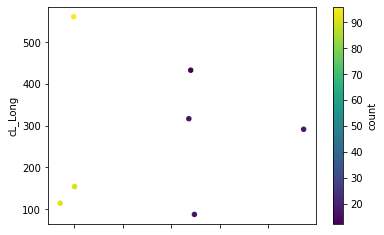

In [109]:
plot_bygroup_df.plot.scatter(x='cL_Lat',y='cL_Long',c='count',colormap='viridis')

In [119]:
plot_df[['cL_Lat', 'cL_Long']].dropna()

,cL_Lat,cL_Long
0,298.481481,561.222222
1,298.481481,561.222222
2,298.481481,561.222222
3,298.481481,561.222222
4,298.481481,561.222222
...,...,...
347,298.481481,561.222222
348,298.481481,561.222222
349,298.481481,561.222222
350,298.481481,561.222222


In [123]:
nonNAN_index = plot_df[['cL_Lat', 'cL_Long']].dropna().index

In [126]:
X = np.array(plot_df.iloc[nonNAN_index,:][['cL_Lat', 'cL_Long']] )

In [129]:
len(nonNAN_index)

340

In [130]:
X[60]

array([539.83333333, 433.16666667])

In [131]:
X.shape

(340, 2)

In [132]:
type(X[0,0])

numpy.float64

In [134]:
 np.isfinite(X).all()

True

In [135]:
X.shape

(340, 2)

In [145]:
int(np.ceil(X.shape[0]/50))

7

In [146]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=int(np.ceil(X.shape[0]/50)), random_state=0).fit(X)

In [140]:
kmeans.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

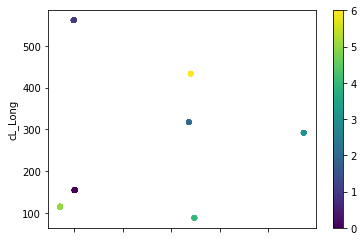

In [148]:
plot_df.iloc[nonNAN_index,:].plot.scatter(x='cL_Lat',y='cL_Long',c=kmeans.labels_,colormap='viridis')